# Practical 7
## To study Transfer Learning using Convolutional Neural Networks.


### 1. Theory (compact, practical)
**What is transfer learning?**  
Transfer learning reuses a model (or its features) trained on a large dataset (usually ImageNet) to solve a new, typically smaller, task. It speeds training, improves performance when data is limited, and reduces compute.

**Two common modes**
- **Feature extraction (fixed backbone):** freeze pretrained convolutional layers, replace the top/classifier with a new head, train only the new head. Fast and less likely to overfit when data is small.
- **Fine-tuning:** start from pretrained weights, unfreeze some (or all) pretrained layers and train with a small learning rate. Useful when your target domain differs from pretraining data or when you have moderate data.

**Practical steps**
1. Choose a backbone (ResNet, EfficientNet, MobileNet, etc.) based on accuracy vs latency.
2. Resize inputs to the model's expected size. Use the model's recommended preprocessing function (scaling, mean subtraction, etc.).
3. Start with feature extraction (freeze backbone). If performance plateaus, unfreeze top blocks and fine-tune with a smaller LR (e.g., 10× smaller).
4. Use data augmentation, weight decay, early stopping, and learning-rate schedules.
5. When using batch normalization layers: when fine-tuning, either keep them in train mode (careful) or freeze them to avoid mismatch with small batch sizes.

**example usage**
- For mobile/edge applications use MobileNet / EfficientNet-lite.
- If input distribution is different (medical, infrared), fine-tune earlier layers.
- Use class-balanced sampling or focal loss for imbalanced tasks.
- Monitor validation metrics, not only loss, during fine-tuning.

---


#### Popular pretrained CNNs

<table>
  <thead>
    <tr>
      <th style="text-align:left">Model</th>
      <th style="text-align:left">Typical input size (HxW)</th>
      <th style="text-align:left">Keras / TF import</th>
      <th style="text-align:left">PyTorch import (torchvision)</th>
      <th style="text-align:left">Notes</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>VGG16</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td><code>models.vgg16(pretrained=True)</code></td>
      <td>Simple, large parameters, baseline for many experiments.</td>
    </tr>
    <tr>
      <td>ResNet50</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td><code>models.resnet50(pretrained=True)</code></td>
      <td>Good accuracy/complexity tradeoff; many variants available.</td>
    </tr>
    <tr>
      <td>InceptionV3</td>
      <td>299×299</td>
      <td><code>tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))</code></td>
      <td><code>models.inception_v3(pretrained=True)</code></td>
      <td>Optimized for larger input (299).</td>
    </tr>
    <tr>
      <td>Xception</td>
      <td>299×299</td>
      <td><code>tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))</code></td>
      <td>— (not in torchvision; use other repos or TF)</td>
      <td>Depthwise-separable convs; available in Keras.</td>
    </tr>
    <tr>
      <td>MobileNetV2</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td><code>models.mobilenet_v2(pretrained=True)</code></td>
      <td>Lightweight; suited for mobile/edge.</td>
    </tr>
    <tr>
      <td>EfficientNetB0</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td><code>models.efficientnet_b0(pretrained=True)</code></td>
      <td>State-of-the-art accuracy/efficiency family (B0..B7).</td>
    </tr>
    <tr>
      <td>EfficientNetB4</td>
      <td>380×380</td>
      <td><code>tf.keras.applications.EfficientNetB4(..., input_shape=(380,380,3))</code></td>
      <td><code>models.efficientnet_b4(pretrained=True)</code></td>
      <td>Higher accuracy; larger input and compute.</td>
    </tr>
    <tr>
      <td>DenseNet121</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td><code>models.densenet121(pretrained=True)</code></td>
      <td>Feature reuse via dense connections; parameter-efficient.</td>
    </tr>
    <tr>
      <td>NASNetMobile</td>
      <td>224×224</td>
      <td><code>tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(224,224,3))</code></td>
      <td>— (use TF or other third-party)</td>
      <td>Architecture found by NAS; efficient mobile variant.</td>
    </tr>
    <tr>
      <td>ResNeXt50 / ResNeXt101</td>
      <td>224×224</td>
      <td>— (use tf.keras.applications or third-party)</td>
      <td><code>models.resnext50_32x4d(pretrained=True)</code></td>
      <td>Improves accuracy via grouped convolutions.</td>
    </tr>
    <tr>
      <td>ConvNeXt (tiny / base)</td>
      <td>224×224</td>
      <td>— (available in TF community or use Hugging Face)</td>
      <td><code>models.convnext_tiny(pretrained=True)</code></td>
      <td>Modernized ResNet-style CNN with transformer ideas.</td>
    </tr>
  </tbody>
</table>

---

---

## Preprocessing 

**Keras / TF:** each model has a preprocessing function, e.g.  
- `tf.keras.applications.resnet.preprocess_input`  
- `tf.keras.applications.efficientnet.preprocess_input`  

These typically convert RGB uint8 to float, scale and/or subtract ImageNet means.

**PyTorch (torchvision):** typical transform for models trained on ImageNet:
```python
transforms.Compose([
    transforms.Resize(size),                # resize shortest side (or center crop to fixed size)
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),                  # converts to [0,1]
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
```
---

---

## When to Use Which Model (by task size, resources, and deployment targetby )

### 1. **Dataset Size**

* **Small dataset (≤ few thousand images):**

  * Use **lightweight or mid-size models** (MobileNet, ResNet18, DenseNet121).
  * Freeze most layers; train only the classifier head.
* **Medium dataset (10k–100k images):**

  * Use **ResNet50, EfficientNet-B0/B2, InceptionV3**.
  * Fine-tune last 1–2 blocks.
* **Large dataset (100k+ images, domain-specific):**

  * Consider **full fine-tuning** of deeper models like **EfficientNet-B4/B7, ResNeXt101, ConvNeXt**.
  * Use larger input resolution if compute allows.

---

### 2. **Compute & Memory Budget**

* **Limited compute / mobile deployment:**

  * Use **MobileNetV2/V3, EfficientNet-Lite, NASNetMobile**.
  * Trade some accuracy for speed/low memory.
* **Moderate GPU (e.g., 1 GPU with 8–12 GB VRAM):**

  * Use **ResNet50, DenseNet121, EfficientNet-B0/B2**.
* **High compute (multi-GPU / TPU):**

  * Train **deeper variants** (EfficientNet-B4–B7, ResNeXt101, ConvNeXt).
  * Useful for very large datasets.

---

### 3. **Accuracy vs Speed Trade-off**

* **Prioritize speed (real-time inference):**

  * MobileNetV2, EfficientNet-Lite, ShuffleNet.
* **Balanced accuracy vs speed:**

  * ResNet50, EfficientNet-B0/B2, DenseNet121.
* **Prioritize accuracy (not latency-critical):**

  * EfficientNet-B4/B7, ConvNeXt, Inception-ResNet.

---

### 4. **Domain Similarity**

* **Natural images (close to ImageNet):**

  * Any backbone works well — start with ResNet/EfficientNet.
* **Medical, satellite, or non-natural images:**

  * Fine-tune earlier layers, or use domain-pretrained backbones (if available).
  * ResNet and DenseNet often transfer well.

---

### 5. **Task Type**

* **Classification (standard):**

  * ResNet, EfficientNet, DenseNet → safe defaults.
* **Detection / segmentation:**

  * Use backbones like ResNet50/101, EfficientNet, or MobileNet in detection frameworks (Faster R-CNN, YOLO, Mask R-CNN, DeepLab).
* **Lightweight edge tasks (embedded devices):**

  * MobileNet, NASNetMobile, EfficientNet-Lite.
* **High-resolution tasks (fine-grained recognition):**

  * InceptionV3 (299×299), EfficientNet-B4+ (≥380×380).

---

**Rule of Thumb**

* Start simple → **ResNet50 or EfficientNet-B0**.
* If accuracy insufficient and you have more data/compute → scale up to **EfficientNet-B4/ConvNeXt**.
* If deploying to mobile → **MobileNet/EfficientNet-Lite**.
* If dataset is very small → freeze backbone, train only head.

---


---

## When to Use Which Pretrained Model (By Task)

### **1. Image Classification**

* **General-purpose / balanced tasks** → **ResNet50, EfficientNet-B0/B2** (default backbones).
* **Small datasets** → Freeze most of **MobileNetV2/DenseNet121**, train only classifier.
* **Fine-grained classification** (birds, flowers, diseases) → **InceptionV3, EfficientNet-B4+** (high-resolution input helps).
* **Mobile/edge classification** → **MobileNetV2/V3, EfficientNet-Lite**.

---

### **2. Object Detection**

* **Standard detection (COCO-like datasets)** → **ResNet50/101 backbones** with Faster R-CNN, RetinaNet, YOLO.
* **Resource-limited edge detection** → **MobileNet + SSD / YOLOv5n**.
* **High-accuracy detection** → **EfficientDet (EfficientNet backbone)**, **ResNeXt101**, or **ConvNeXt**.

---

### **3. Semantic Segmentation**

* **General segmentation (medical, satellite, urban scenes)** → **ResNet50/101 backbones** in DeepLabV3, U-Net++.
* **Resource-limited segmentation** → **MobileNetV2 + DeepLabV3 (lightweight)**.
* **High-resolution fine segmentation** → **HRNet, EfficientNet backbones**.

---

### **4. Medical Imaging**

* **X-rays, MRIs, CT scans** (domain shift from ImageNet):

  * Start with **ResNet18/50 or DenseNet121** (good feature extractors).
  * Fine-tune earlier layers (not just last block).
* **Small dataset** → Freeze backbone, add strong regularization.

---

### **5. Satellite / Remote Sensing**

* Use models with **larger receptive fields**: **EfficientNet-B4+, ResNet101, ConvNeXt**.
* If compute-limited → **MobileNet + segmentation/detection head**.

---

### **6. Fine-Grained Recognition**

* Examples: species classification, fashion, product recognition.
* Use **InceptionV3, EfficientNet-B3/B4, Vision Transformers (ViT)** for **high input resolution**.

---

### **7. Video Tasks (Action Recognition, Tracking)**

* Start with **2D CNN backbone (ResNet50, EfficientNet)** + temporal modeling (LSTM/transformer).
* For heavy tasks → **3D CNN backbones (I3D, SlowFast with ResNet101)**.

---

### **8. Natural Language + Vision (Multimodal)**

* For tasks like **image captioning, VQA**:

  * Use **ResNet/EfficientNet** as the vision backbone.
  * Or **ViT (Vision Transformer)** for transformer-based multimodal models.

---

**Rules of Thumb**

* **Classification →** ResNet, EfficientNet (default).
* **Detection →** ResNet50/101, EfficientDet.
* **Segmentation →** ResNet50/101, HRNet, DeepLab with MobileNet (lightweight).
* **Medical →** ResNet/DenseNet with early fine-tuning.
* **Mobile →** MobileNet, EfficientNet-Lite.
* **High-resolution fine-grained →** Inception, EfficientNet-B4+.
* **Video →** ResNet + temporal model, or 3D CNNs.

---


### Dataset Used
The CIFAR-10 dataset is a popular benchmark dataset in the field of computer vision, consisting of 60,000 32x32 color images in 10 classes : airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

### Import Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

2025-09-30 13:32:04.411661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759239124.588504      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759239124.646470      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load CIFAR-10 dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


I0000 00:00:1759239151.002697      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759239151.003359      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


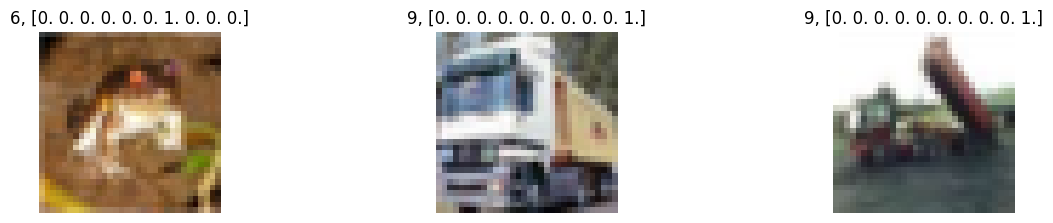

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
x_train_small = x_train[:5000]
y_train_small = y_train[:5000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]
x_train = x_train_small
y_train = y_train_small
y_test = y_test_small
x_test = x_test_small
train_images=x_train
train_labels=y_train.flatten()
plt.figure(figsize=(20, 20))
plot_index = 1
num_images = 3  # Number of images to plot

for i in range(num_images):
    plt.subplot(10, 10, plot_index)  # Adjust grid to fit images
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"{train_labels[i]}, {tf.one_hot(train_labels[i], 10)}")
    plt.axis("off")
    plot_index += 2

plt.tight_layout()
plt.show()

NUM_CLASSES = 10
IMG_SIZE = (224, 224)   # ResNet50 expects 224x224
BATCH_SIZE = 64

# one-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

### Preprocess: resize and normalize using tf.data

In [ ]:
def preprocess(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    images = preprocess_input(images)  # VGG16 preprocessing
    return images, labels

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)


### Build model: ResNet50 base + custom head
#### Freeze the Base Model Layers. To prevent the pre-trained weights from being updated during the initial training of the new layers, set trainable=False for the base_model.

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # Phase A: freeze all

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
1e-2

0.01

### Compile and train model

In [ ]:
model.compile(optimizer=optimizers.Adamax(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_head = model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20


I0000 00:00:1759239168.431600      96 service.cc:148] XLA service 0x7d12c004ce40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759239168.432483      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759239168.432508      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759239169.914973      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/79 ━━━━━━━━━━━━━━━━━━━━ 24:14 19s/step - accuracy: 0.0938 - loss: 4.5673

I0000 00:00:1759239177.127978      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 347ms/step - accuracy: 0.4052 - loss: 2.0988 - val_accuracy: 0.8250 - val_loss: 0.5865
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.7259 - loss: 0.8171 - val_accuracy: 0.8560 - val_loss: 0.4722
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.7691 - loss: 0.6942 - val_accuracy: 0.8510 - val_loss: 0.4428
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.7896 - loss: 0.6122 - val_accuracy: 0.8650 - val_loss: 0.4194
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.7977 - loss: 0.5475 - val_accuracy: 0.8510 - val_loss: 0.4228
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.8037 - loss: 0.5484 - val_accuracy: 0.8730 - val_loss: 0.3904
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.8195 - loss: 0.4949 - val_accuracy: 0.8720 - val_loss: 0.3895
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step - accuracy: 0.8464 - loss: 0.4535 - val_accuracy: 0.874

### Visualize the model architecture with visualkeras and tf.keras.utils.plot_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 9.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


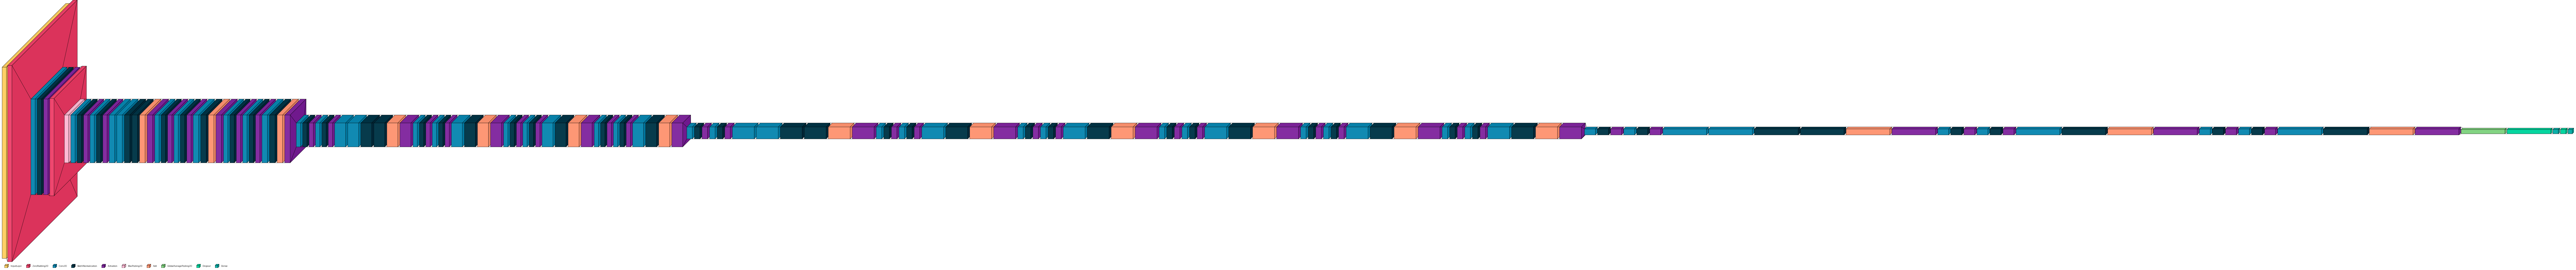

"dot" with args ['-Tpng', '/tmp/tmpvd32fr4h/tmpd5v57j8_'] returned code: -6

stdout, stderr:
 b''
b"failed at node 10634[1]\ndot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.\n"

plot_model error (needs graphviz/pydot): "dot" with args ['-Tpng', '/tmp/tmpvd32fr4h/tmpd5v57j8_'] returned code: -6


In [7]:
# Visualize the model architecture with visualkeras and tf.keras.utils.plot_model
try:
    import visualkeras
except Exception:
    # in a Jupyter notebook use %pip; fallback uses sys.executable for script contexts
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "visualkeras", "graphviz", "pydot"])
    import visualkeras
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import os

# 1) visualkeras layered view (PIL image saved)
try:
    visualkeras.layered_view(model, legend=True, to_file="model_visual.png")
    if os.path.exists("model_visual.png"):
        display(Image("model_visual.png"))
except Exception as e:
    print("visualkeras error:", e)

# 2) Keras plot_model (requires graphviz + pydot)
try:
    plot_model(model, to_file="model_graph.png", show_shapes=True, show_layer_names=True)
    if os.path.exists("model_graph.png"):
        display(Image("model_graph.png"))
except Exception as e:
    print("plot_model error (needs graphviz/pydot):", e)


### Evaluate models final Val_Loss and Val_Accuracy after being trained

In [8]:
model.evaluate(val_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8853 - loss: 0.3451


[0.3406432867050171, 0.8880000114440918]

### Make Prediction to test the model

In [9]:
# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def plot_cifar_predictions(model, x_test, y_test, num_images=5, img_size=(224, 224)):
    """
    Plot CIFAR-10 test images with predicted and true labels (with one-hot).
    
    Args:
        model: Trained Keras model.
        x_test: Test images (numpy array, shape (N, 32, 32, 3)).
        y_test: One-hot encoded test labels (numpy array, shape (N, 10)).
        num_images: Number of test samples to visualize.
        img_size: Target size for ResNet50 preprocessing.
    """
    plt.figure(figsize=(12, 12))
    plot_index = 1

    for i in range(num_images):
        # Extract one image and its label
        sample = x_test[i:i+1]   # (1, 32, 32, 3)
        true = y_test[i]         # one-hot vector

        # Resize + preprocess for ResNet50
        sample_resized = tf.image.resize(sample, img_size)      # (1, 224, 224, 3)
        sample_resized = preprocess_input(sample_resized)       # ResNet50 preprocessing

        # Predict
        pred = model.predict(sample_resized, verbose=0)
        predicted_label = np.argmax(pred)
        true_label = np.argmax(true)

        # Show original CIFAR-10 image (not resized)
        plt.subplot(3, 3, plot_index)
        plt.imshow(x_test[i])

        # Pick color: green if correct, red if wrong
        color = "green" if predicted_label == true_label else "red"
        
        plt.title(
            f"Pred: {predicted_label} ({class_names[predicted_label]})\n{pred[0].round(2)}\n"
            f"True: {true_label} ({class_names[true_label]})\n{true}",
            color=color,
            fontsize=8
        )
        plt.axis("off")
        plot_index += 1

    plt.tight_layout()
    plt.show()

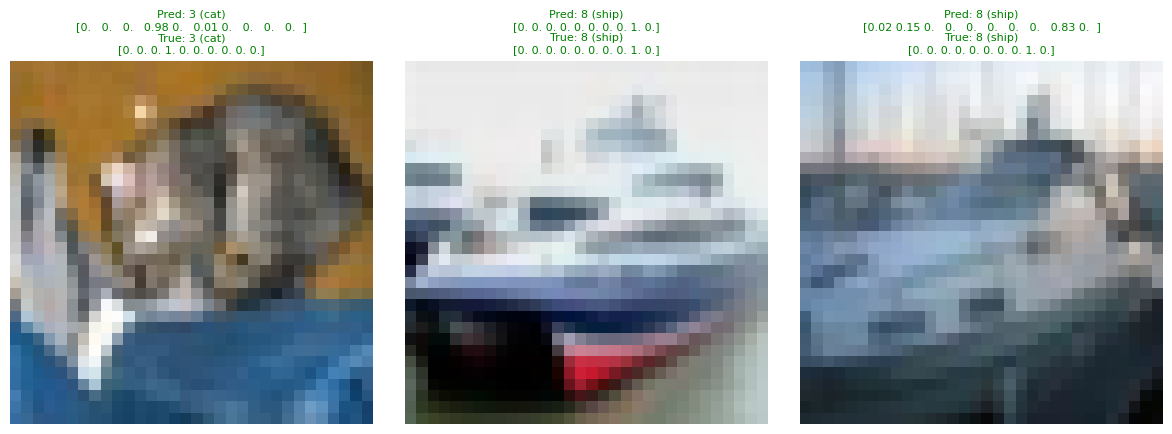

In [10]:
plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)


### Generating model training plot

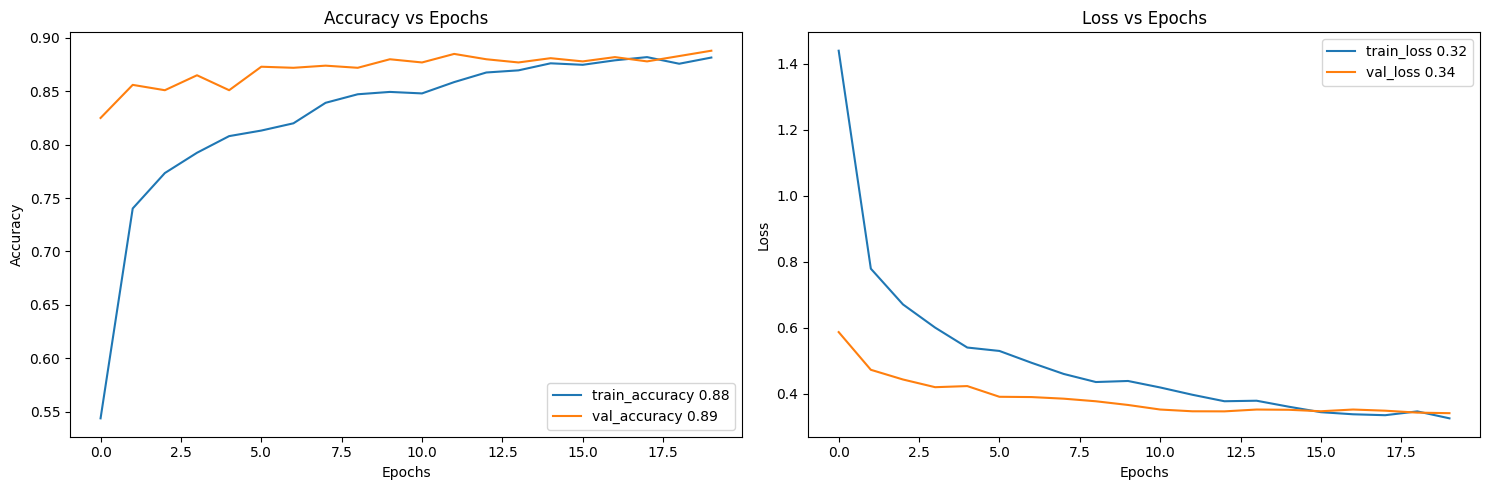

In [11]:
def sub_plot_graph(history, title1, title2):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"train_accuracy {history.history['accuracy'][-1]:.2f}")
    plt.plot(history.history['val_accuracy'], label=f"val_accuracy {history.history['val_accuracy'][-1]:.2f}")
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"train_loss {history.history['loss'][-1]:.2f}")
    plt.plot(history.history['val_loss'], label=f"val_loss {history.history['val_loss'][-1]:.2f}")
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

sub_plot_graph(history_head, "Accuracy vs Epochs", "Loss vs Epochs")

In [12]:
len(model.layers)

180

### Number of layers in base model

In [13]:
len(base_model.layers)

175

### Unfreezing Model Step by step

In [14]:
def unfreeze_slice(index):
    for i, layer in enumerate(base_model.layers[index:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {index + i})")


=== Unfreezing last 5 layers ===
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Validation loss: 0.6248, Validation accuracy: 0.8660


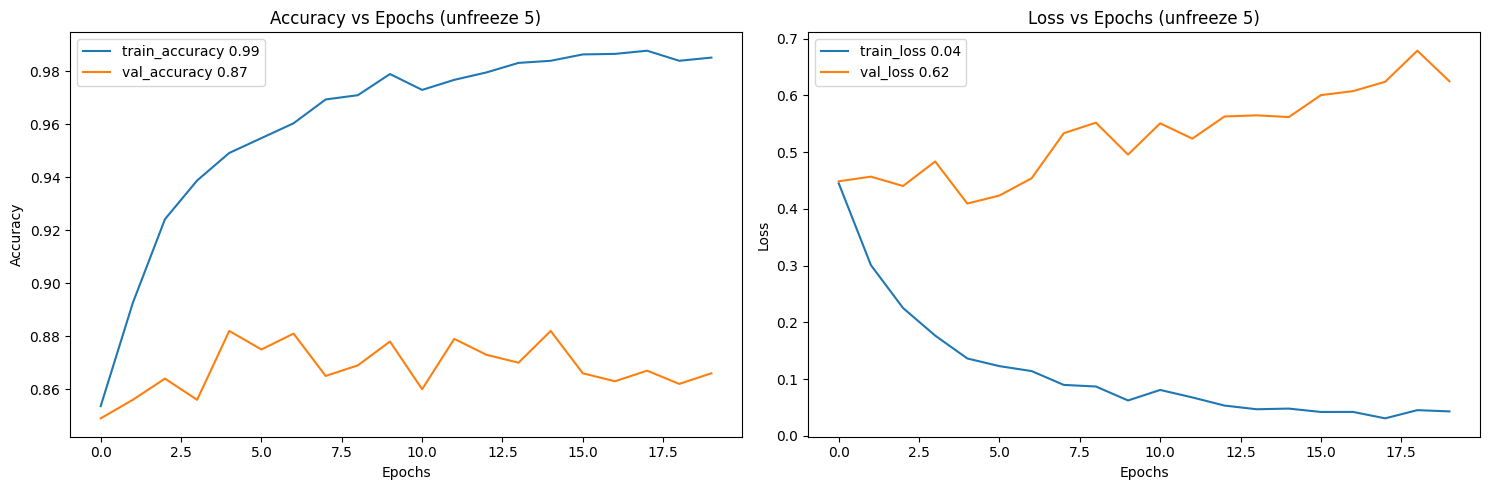

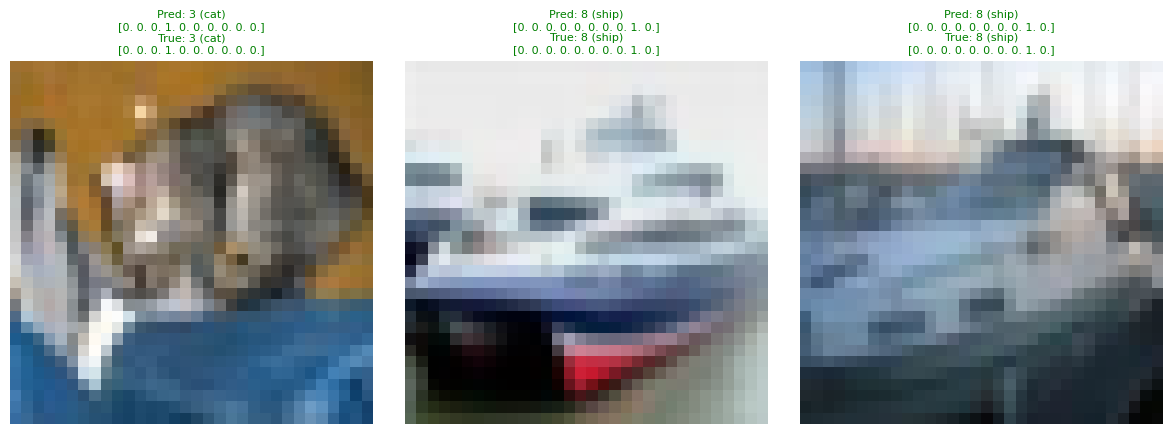


=== Unfreezing last 10 layers ===
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Validation loss: 0.8834, Validation accuracy: 0.8690


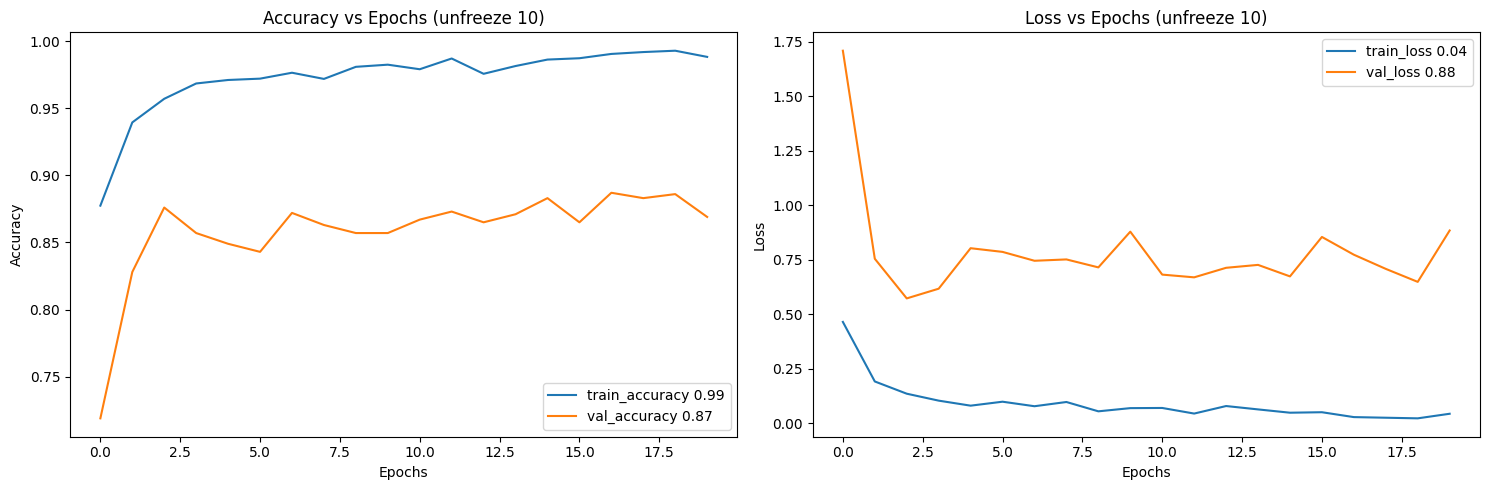

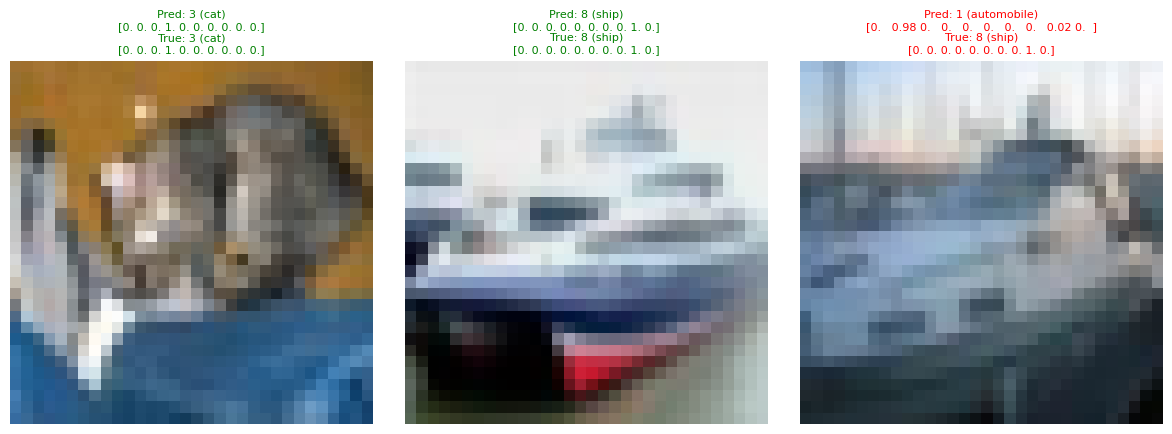


=== Unfreezing last 15 layers ===
Unfrozen: conv5_block2_2_relu (index 160)
Unfrozen: conv5_block2_3_conv (index 161)
Unfrozen: conv5_block2_3_bn (index 162)
Unfrozen: conv5_block2_add (index 163)
Unfrozen: conv5_block2_out (index 164)
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Validation loss: 0.6626, Validation accuracy: 0.8920


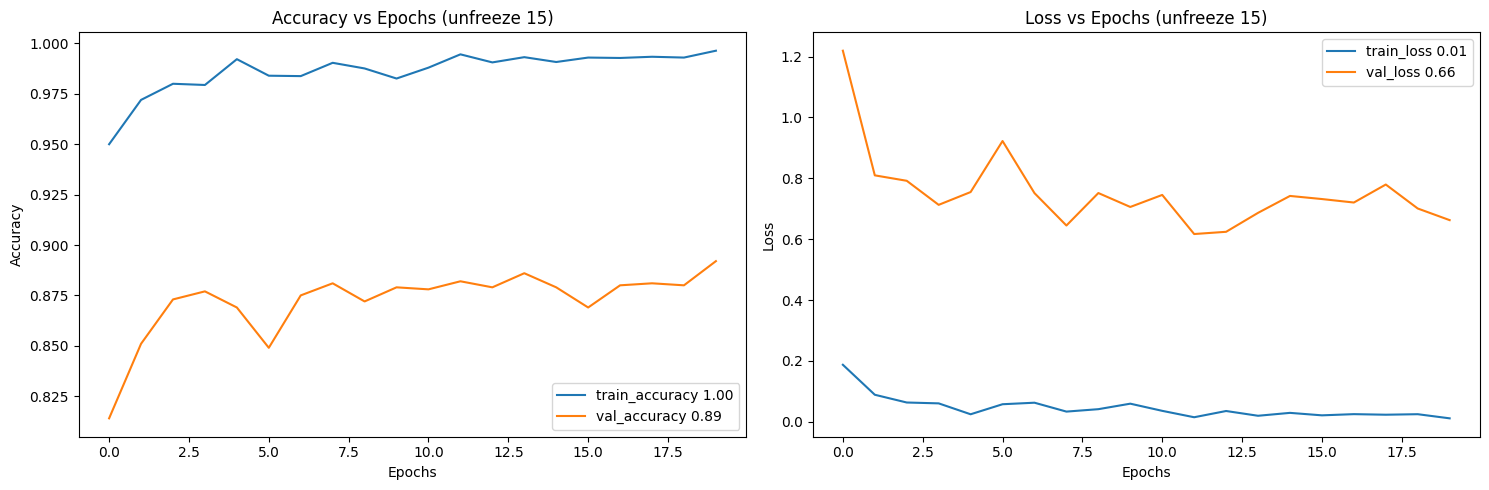

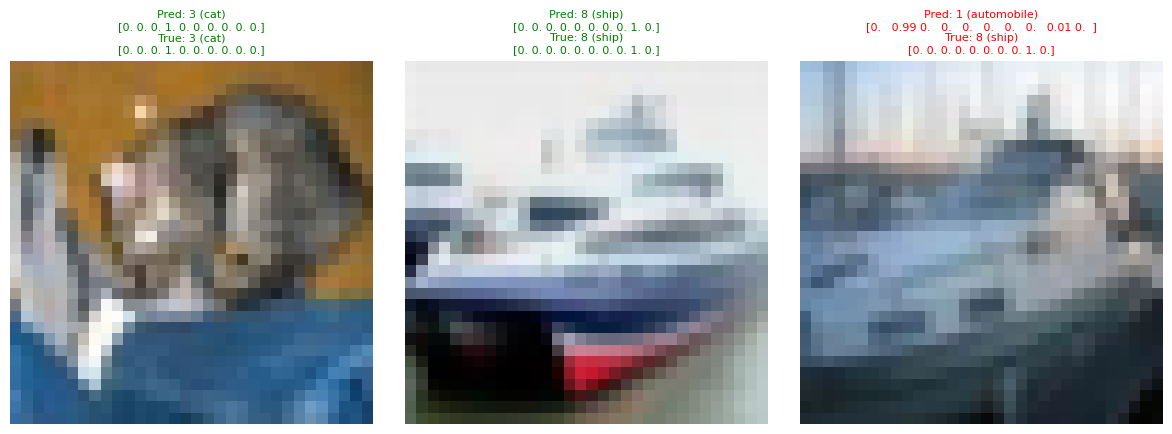


=== Unfreezing last 20 layers ===
Unfrozen: conv5_block2_1_conv (index 155)
Unfrozen: conv5_block2_1_bn (index 156)
Unfrozen: conv5_block2_1_relu (index 157)
Unfrozen: conv5_block2_2_conv (index 158)
Unfrozen: conv5_block2_2_bn (index 159)
Unfrozen: conv5_block2_2_relu (index 160)
Unfrozen: conv5_block2_3_conv (index 161)
Unfrozen: conv5_block2_3_bn (index 162)
Unfrozen: conv5_block2_add (index 163)
Unfrozen: conv5_block2_out (index 164)
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add (index 173)
Unfrozen: conv5_block3_out (index 174)
Validation loss: 0.7795, Validation accuracy: 0.8770


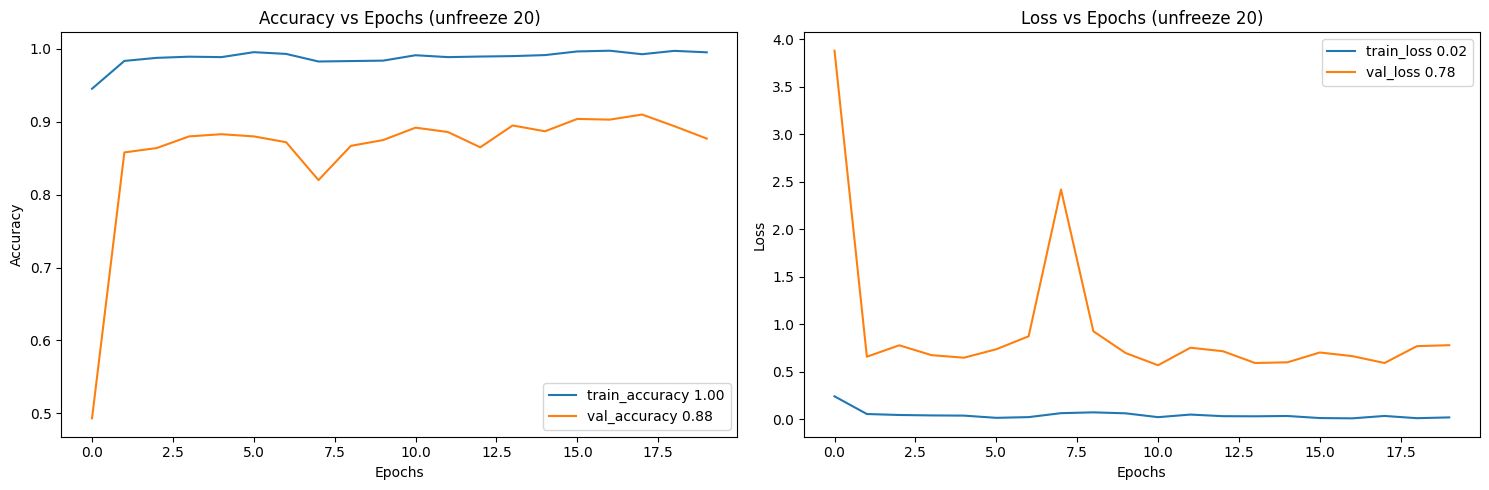

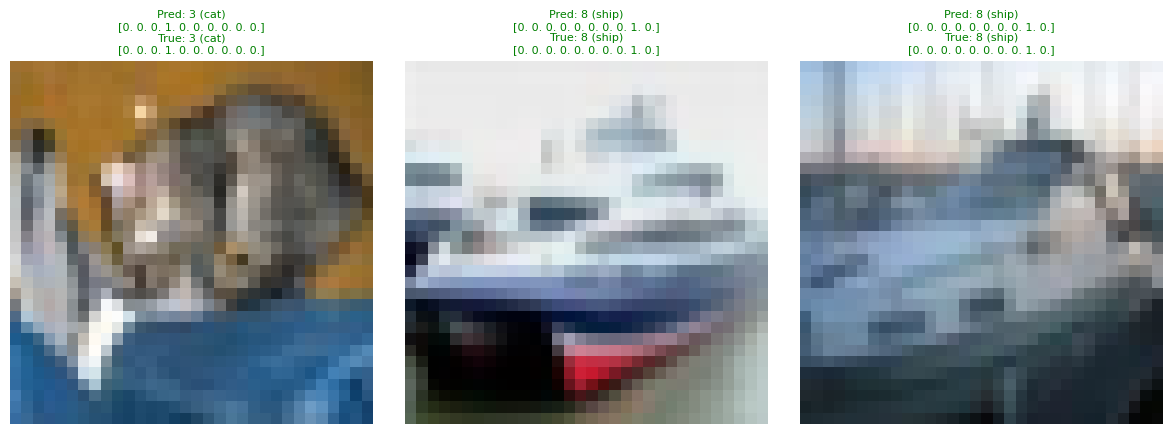


=== Unfreezing last 25 layers ===
Unfrozen: conv5_block1_3_conv (index 150)
Unfrozen: conv5_block1_0_bn (index 151)
Unfrozen: conv5_block1_3_bn (index 152)
Unfrozen: conv5_block1_add (index 153)
Unfrozen: conv5_block1_out (index 154)
Unfrozen: conv5_block2_1_conv (index 155)
Unfrozen: conv5_block2_1_bn (index 156)
Unfrozen: conv5_block2_1_relu (index 157)
Unfrozen: conv5_block2_2_conv (index 158)
Unfrozen: conv5_block2_2_bn (index 159)
Unfrozen: conv5_block2_2_relu (index 160)
Unfrozen: conv5_block2_3_conv (index 161)
Unfrozen: conv5_block2_3_bn (index 162)
Unfrozen: conv5_block2_add (index 163)
Unfrozen: conv5_block2_out (index 164)
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_conv (index 168)
Unfrozen: conv5_block3_2_bn (index 169)
Unfrozen: conv5_block3_2_relu (index 170)
Unfrozen: conv5_block3_3_conv (index 171)
Unfrozen: conv5_block3_3_bn (index 172)
Unfrozen: conv5_block3_add 

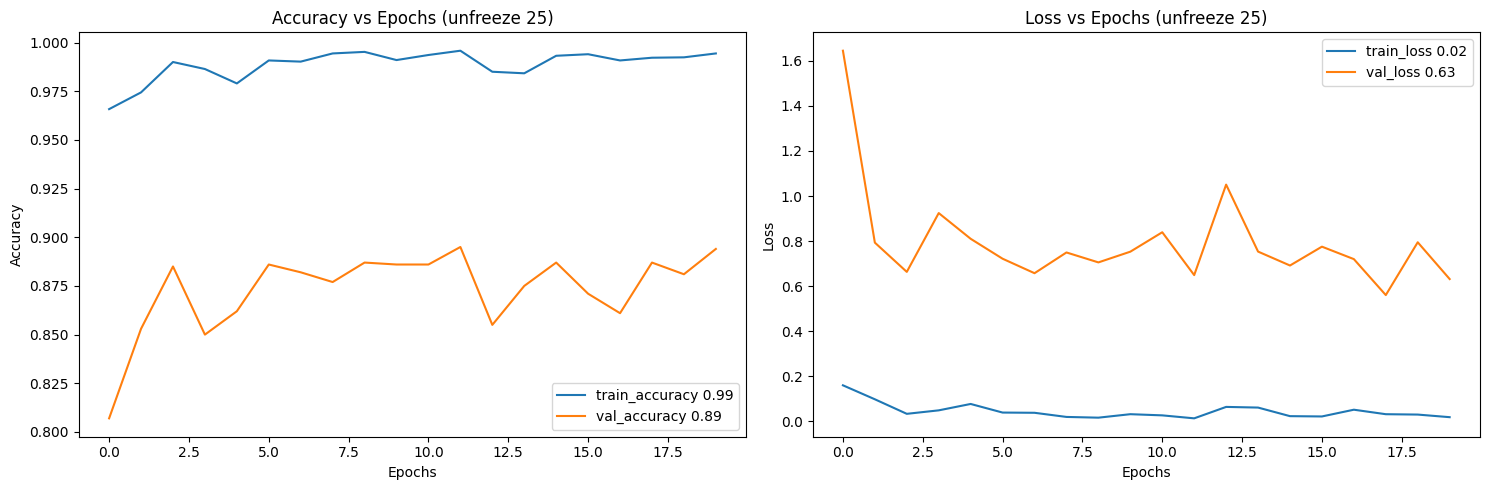

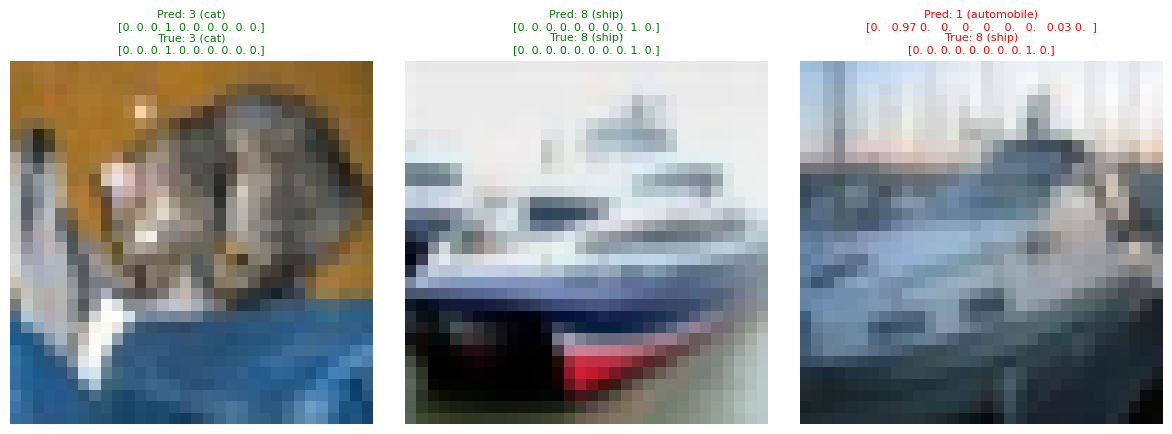


=== Unfreezing last 30 layers ===
Unfrozen: conv5_block1_1_relu (index 145)
Unfrozen: conv5_block1_2_conv (index 146)
Unfrozen: conv5_block1_2_bn (index 147)
Unfrozen: conv5_block1_2_relu (index 148)
Unfrozen: conv5_block1_0_conv (index 149)
Unfrozen: conv5_block1_3_conv (index 150)
Unfrozen: conv5_block1_0_bn (index 151)
Unfrozen: conv5_block1_3_bn (index 152)
Unfrozen: conv5_block1_add (index 153)
Unfrozen: conv5_block1_out (index 154)
Unfrozen: conv5_block2_1_conv (index 155)
Unfrozen: conv5_block2_1_bn (index 156)
Unfrozen: conv5_block2_1_relu (index 157)
Unfrozen: conv5_block2_2_conv (index 158)
Unfrozen: conv5_block2_2_bn (index 159)
Unfrozen: conv5_block2_2_relu (index 160)
Unfrozen: conv5_block2_3_conv (index 161)
Unfrozen: conv5_block2_3_bn (index 162)
Unfrozen: conv5_block2_add (index 163)
Unfrozen: conv5_block2_out (index 164)
Unfrozen: conv5_block3_1_conv (index 165)
Unfrozen: conv5_block3_1_bn (index 166)
Unfrozen: conv5_block3_1_relu (index 167)
Unfrozen: conv5_block3_2_

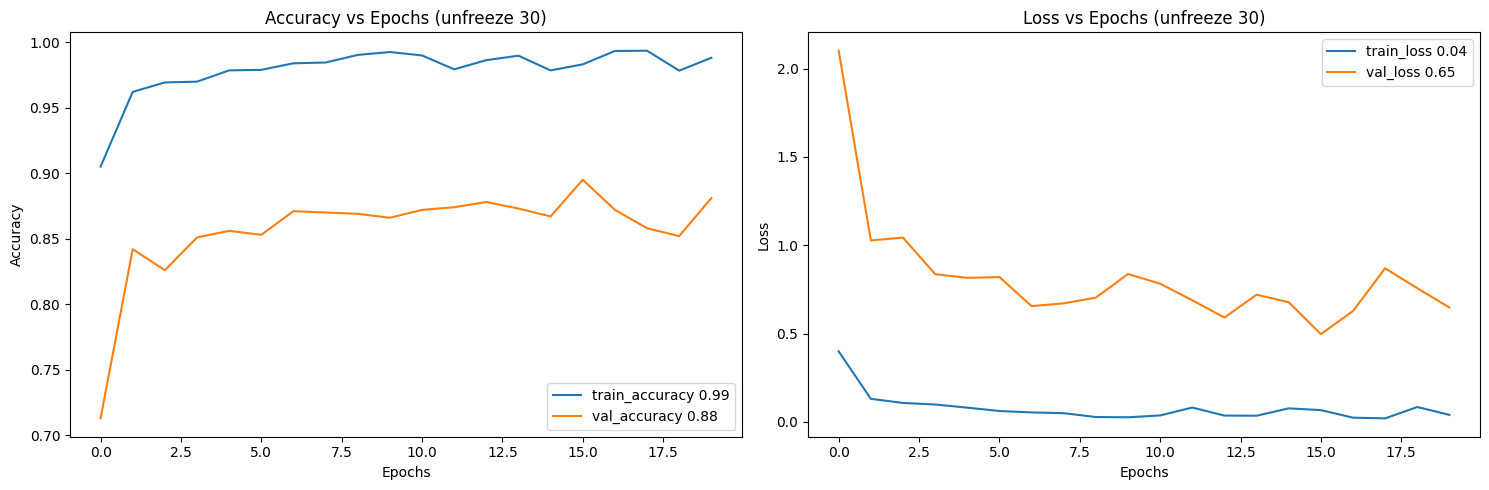

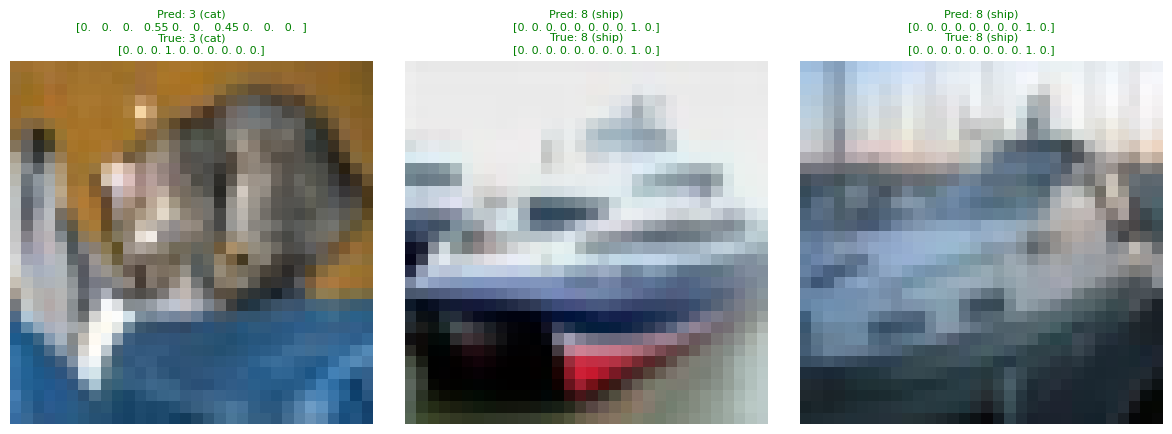


=== Unfreezing last 35 layers ===
Unfrozen: conv4_block6_3_bn (index 140)
Unfrozen: conv4_block6_add (index 141)
Unfrozen: conv4_block6_out (index 142)
Unfrozen: conv5_block1_1_conv (index 143)
Unfrozen: conv5_block1_1_bn (index 144)
Unfrozen: conv5_block1_1_relu (index 145)
Unfrozen: conv5_block1_2_conv (index 146)
Unfrozen: conv5_block1_2_bn (index 147)
Unfrozen: conv5_block1_2_relu (index 148)
Unfrozen: conv5_block1_0_conv (index 149)
Unfrozen: conv5_block1_3_conv (index 150)
Unfrozen: conv5_block1_0_bn (index 151)
Unfrozen: conv5_block1_3_bn (index 152)
Unfrozen: conv5_block1_add (index 153)
Unfrozen: conv5_block1_out (index 154)
Unfrozen: conv5_block2_1_conv (index 155)
Unfrozen: conv5_block2_1_bn (index 156)
Unfrozen: conv5_block2_1_relu (index 157)
Unfrozen: conv5_block2_2_conv (index 158)
Unfrozen: conv5_block2_2_bn (index 159)
Unfrozen: conv5_block2_2_relu (index 160)
Unfrozen: conv5_block2_3_conv (index 161)
Unfrozen: conv5_block2_3_bn (index 162)
Unfrozen: conv5_block2_add 

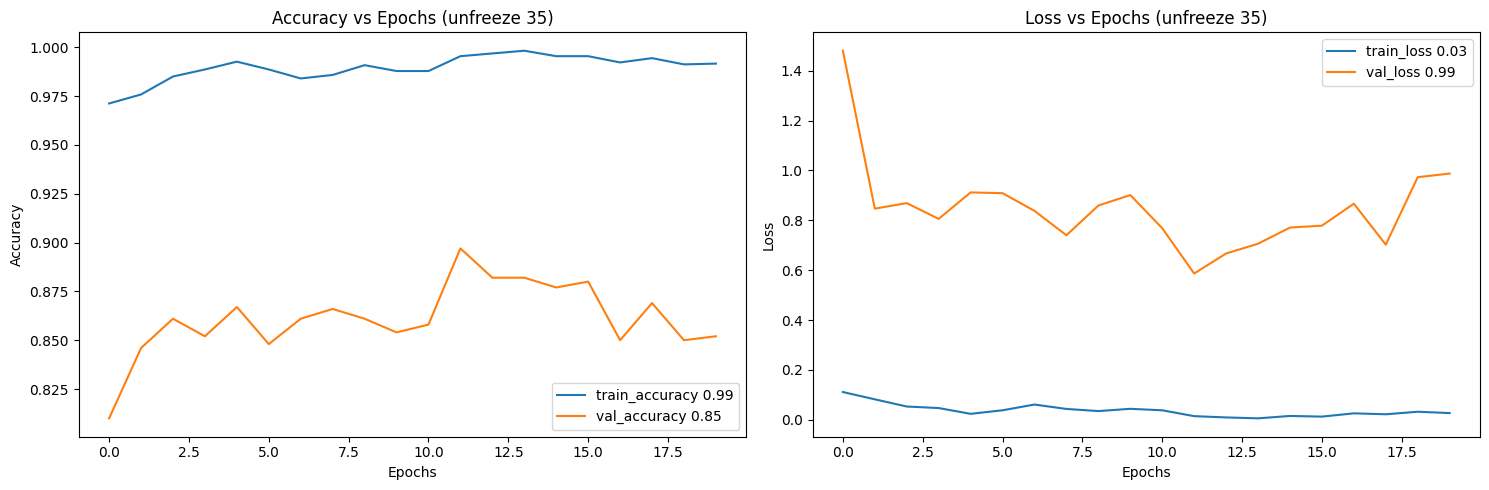

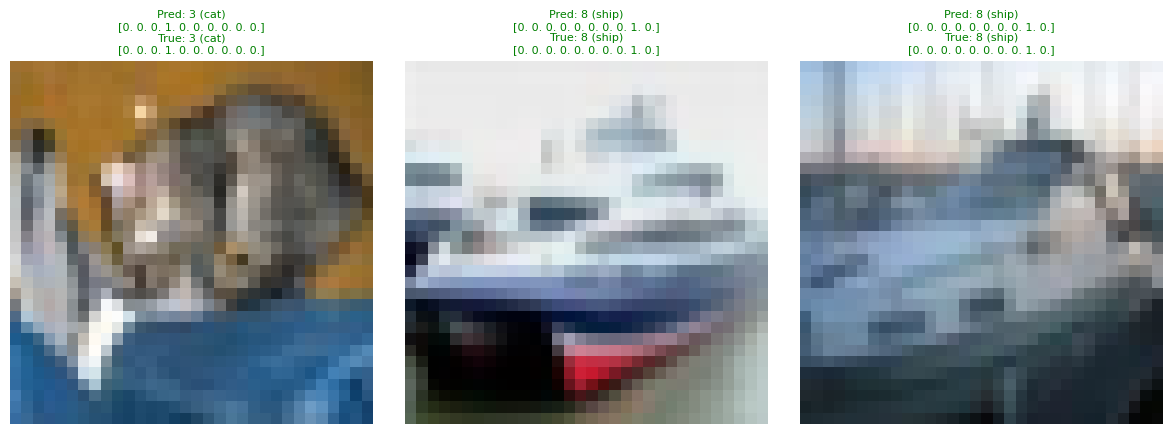


=== Unfreezing last 40 layers ===
Unfrozen: conv4_block6_1_relu (index 135)
Unfrozen: conv4_block6_2_conv (index 136)
Unfrozen: conv4_block6_2_bn (index 137)
Unfrozen: conv4_block6_2_relu (index 138)
Unfrozen: conv4_block6_3_conv (index 139)
Unfrozen: conv4_block6_3_bn (index 140)
Unfrozen: conv4_block6_add (index 141)
Unfrozen: conv4_block6_out (index 142)
Unfrozen: conv5_block1_1_conv (index 143)
Unfrozen: conv5_block1_1_bn (index 144)
Unfrozen: conv5_block1_1_relu (index 145)
Unfrozen: conv5_block1_2_conv (index 146)
Unfrozen: conv5_block1_2_bn (index 147)
Unfrozen: conv5_block1_2_relu (index 148)
Unfrozen: conv5_block1_0_conv (index 149)
Unfrozen: conv5_block1_3_conv (index 150)
Unfrozen: conv5_block1_0_bn (index 151)
Unfrozen: conv5_block1_3_bn (index 152)
Unfrozen: conv5_block1_add (index 153)
Unfrozen: conv5_block1_out (index 154)
Unfrozen: conv5_block2_1_conv (index 155)
Unfrozen: conv5_block2_1_bn (index 156)
Unfrozen: conv5_block2_1_relu (index 157)
Unfrozen: conv5_block2_2_

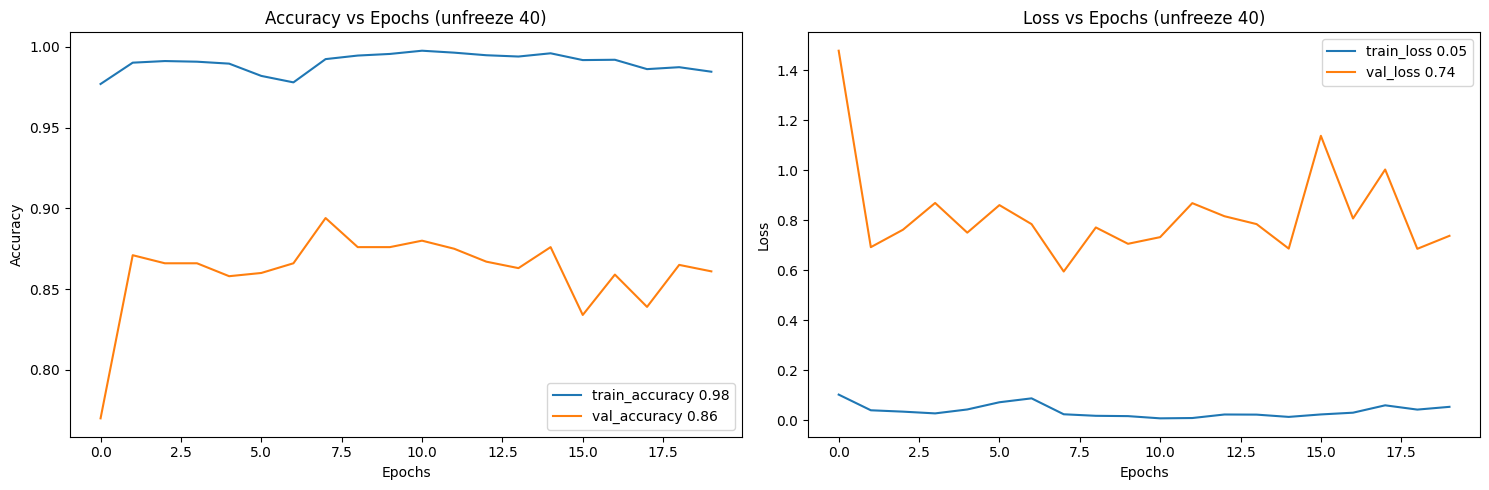

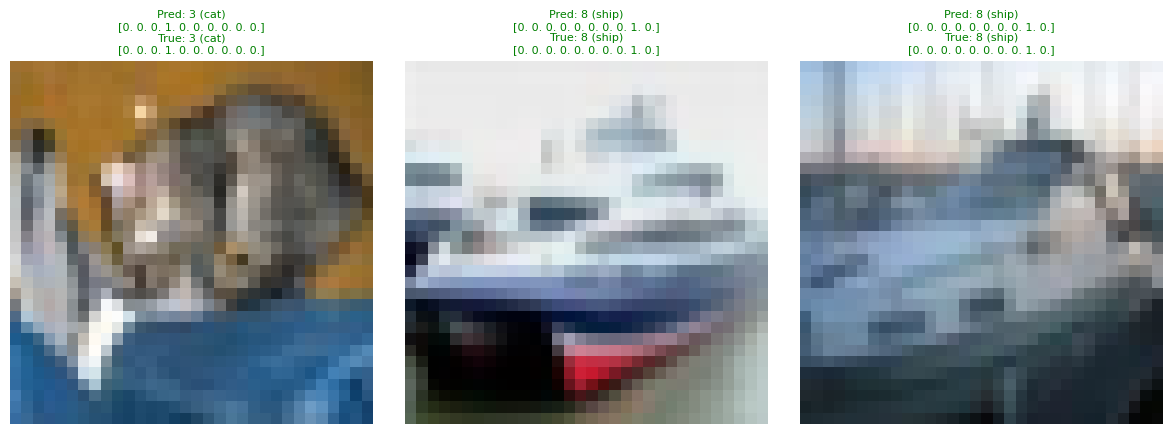


=== Unfreezing last 45 layers ===
Unfrozen: conv4_block5_3_bn (index 130)
Unfrozen: conv4_block5_add (index 131)
Unfrozen: conv4_block5_out (index 132)
Unfrozen: conv4_block6_1_conv (index 133)
Unfrozen: conv4_block6_1_bn (index 134)
Unfrozen: conv4_block6_1_relu (index 135)
Unfrozen: conv4_block6_2_conv (index 136)
Unfrozen: conv4_block6_2_bn (index 137)
Unfrozen: conv4_block6_2_relu (index 138)
Unfrozen: conv4_block6_3_conv (index 139)
Unfrozen: conv4_block6_3_bn (index 140)
Unfrozen: conv4_block6_add (index 141)
Unfrozen: conv4_block6_out (index 142)
Unfrozen: conv5_block1_1_conv (index 143)
Unfrozen: conv5_block1_1_bn (index 144)
Unfrozen: conv5_block1_1_relu (index 145)
Unfrozen: conv5_block1_2_conv (index 146)
Unfrozen: conv5_block1_2_bn (index 147)
Unfrozen: conv5_block1_2_relu (index 148)
Unfrozen: conv5_block1_0_conv (index 149)
Unfrozen: conv5_block1_3_conv (index 150)
Unfrozen: conv5_block1_0_bn (index 151)
Unfrozen: conv5_block1_3_bn (index 152)
Unfrozen: conv5_block1_add 

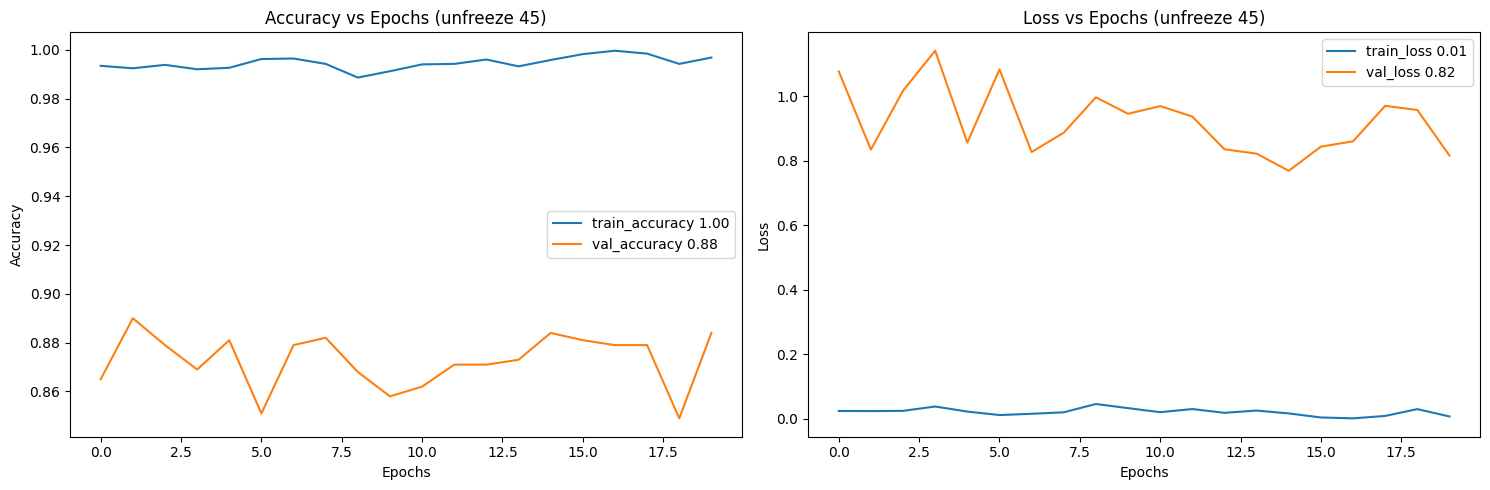

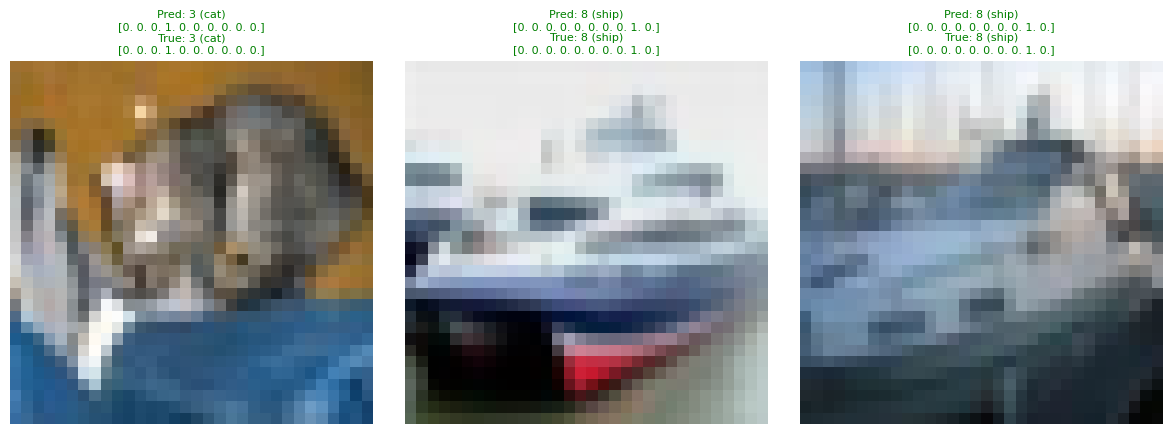


=== Unfreezing last 50 layers ===
Unfrozen: conv4_block5_1_relu (index 125)
Unfrozen: conv4_block5_2_conv (index 126)
Unfrozen: conv4_block5_2_bn (index 127)
Unfrozen: conv4_block5_2_relu (index 128)
Unfrozen: conv4_block5_3_conv (index 129)
Unfrozen: conv4_block5_3_bn (index 130)
Unfrozen: conv4_block5_add (index 131)
Unfrozen: conv4_block5_out (index 132)
Unfrozen: conv4_block6_1_conv (index 133)
Unfrozen: conv4_block6_1_bn (index 134)
Unfrozen: conv4_block6_1_relu (index 135)
Unfrozen: conv4_block6_2_conv (index 136)
Unfrozen: conv4_block6_2_bn (index 137)
Unfrozen: conv4_block6_2_relu (index 138)
Unfrozen: conv4_block6_3_conv (index 139)
Unfrozen: conv4_block6_3_bn (index 140)
Unfrozen: conv4_block6_add (index 141)
Unfrozen: conv4_block6_out (index 142)
Unfrozen: conv5_block1_1_conv (index 143)
Unfrozen: conv5_block1_1_bn (index 144)
Unfrozen: conv5_block1_1_relu (index 145)
Unfrozen: conv5_block1_2_conv (index 146)
Unfrozen: conv5_block1_2_bn (index 147)
Unfrozen: conv5_block1_2_

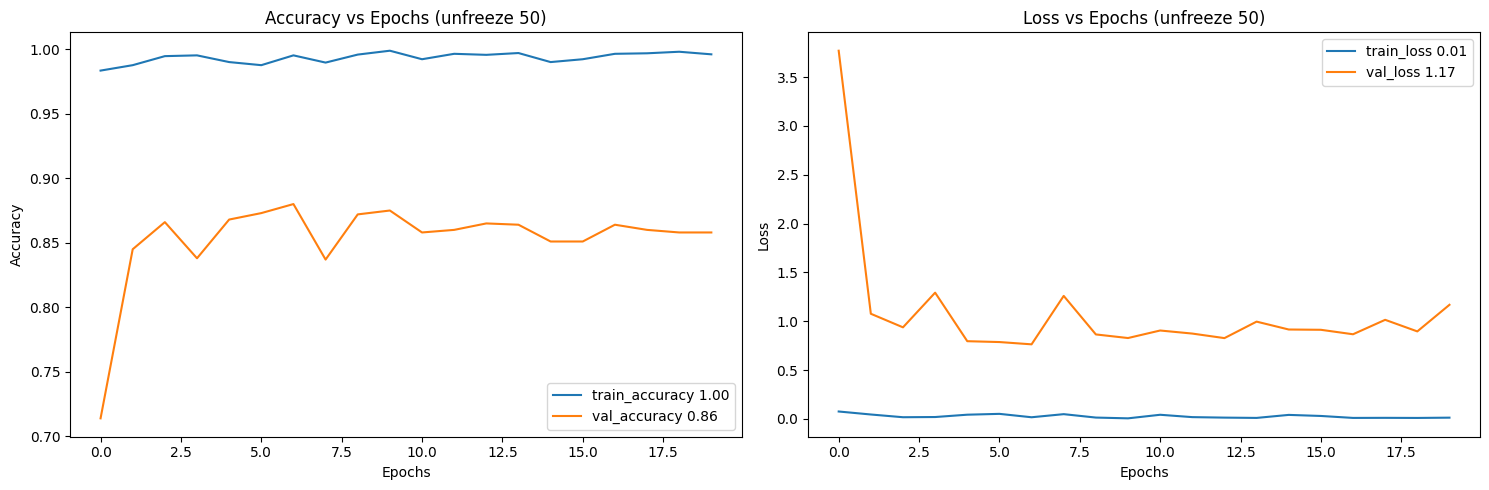

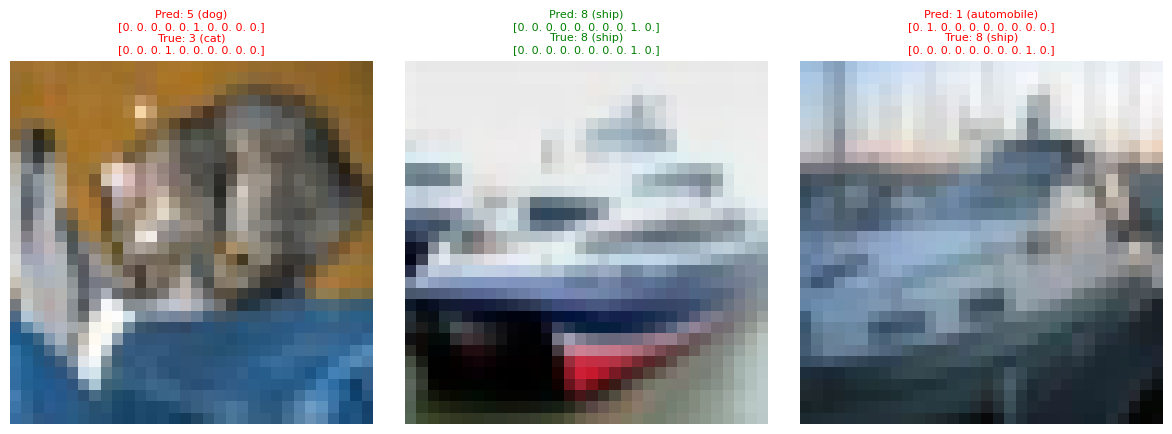


=== Unfreezing last 55 layers ===
Unfrozen: conv4_block4_3_bn (index 120)
Unfrozen: conv4_block4_add (index 121)
Unfrozen: conv4_block4_out (index 122)
Unfrozen: conv4_block5_1_conv (index 123)
Unfrozen: conv4_block5_1_bn (index 124)
Unfrozen: conv4_block5_1_relu (index 125)
Unfrozen: conv4_block5_2_conv (index 126)
Unfrozen: conv4_block5_2_bn (index 127)
Unfrozen: conv4_block5_2_relu (index 128)
Unfrozen: conv4_block5_3_conv (index 129)
Unfrozen: conv4_block5_3_bn (index 130)
Unfrozen: conv4_block5_add (index 131)
Unfrozen: conv4_block5_out (index 132)
Unfrozen: conv4_block6_1_conv (index 133)
Unfrozen: conv4_block6_1_bn (index 134)
Unfrozen: conv4_block6_1_relu (index 135)
Unfrozen: conv4_block6_2_conv (index 136)
Unfrozen: conv4_block6_2_bn (index 137)
Unfrozen: conv4_block6_2_relu (index 138)
Unfrozen: conv4_block6_3_conv (index 139)
Unfrozen: conv4_block6_3_bn (index 140)
Unfrozen: conv4_block6_add (index 141)
Unfrozen: conv4_block6_out (index 142)
Unfrozen: conv5_block1_1_conv (

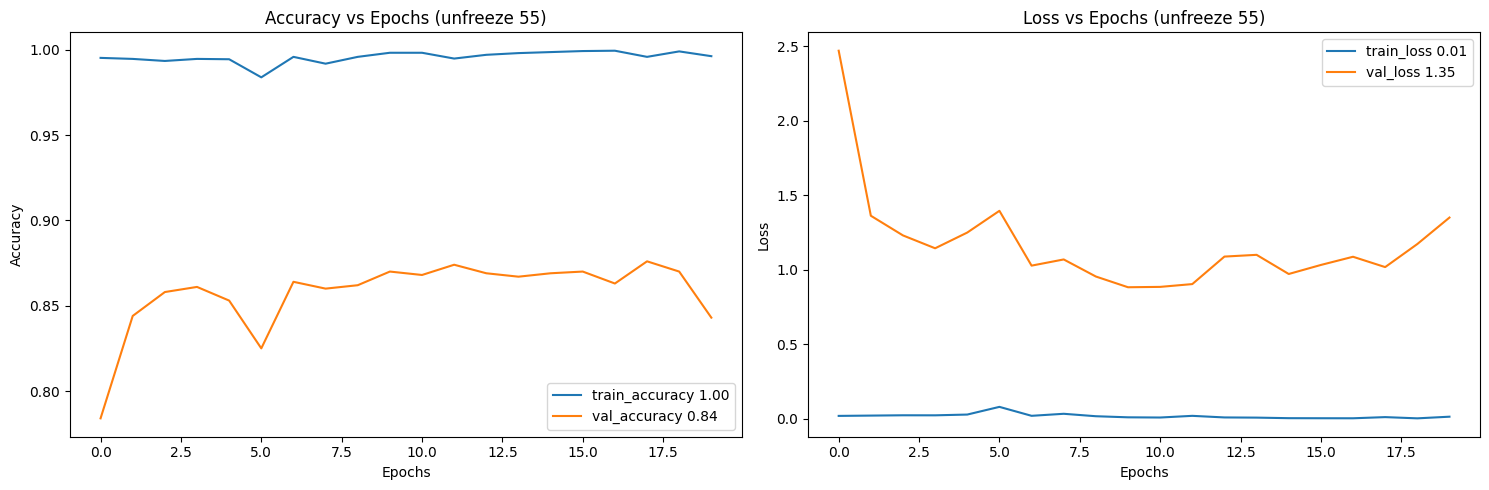

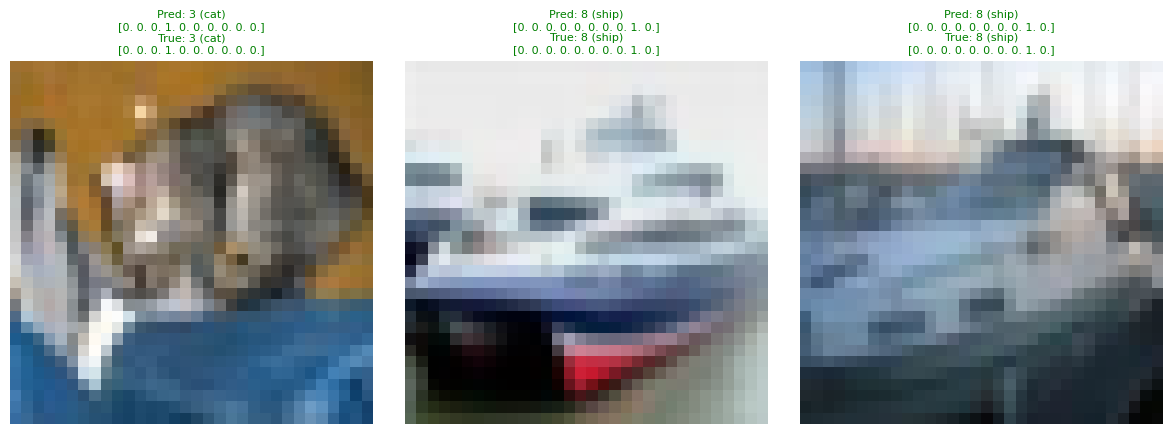


=== Unfreezing last 60 layers ===
Unfrozen: conv4_block4_1_relu (index 115)
Unfrozen: conv4_block4_2_conv (index 116)
Unfrozen: conv4_block4_2_bn (index 117)
Unfrozen: conv4_block4_2_relu (index 118)
Unfrozen: conv4_block4_3_conv (index 119)
Unfrozen: conv4_block4_3_bn (index 120)
Unfrozen: conv4_block4_add (index 121)
Unfrozen: conv4_block4_out (index 122)
Unfrozen: conv4_block5_1_conv (index 123)
Unfrozen: conv4_block5_1_bn (index 124)
Unfrozen: conv4_block5_1_relu (index 125)
Unfrozen: conv4_block5_2_conv (index 126)
Unfrozen: conv4_block5_2_bn (index 127)
Unfrozen: conv4_block5_2_relu (index 128)
Unfrozen: conv4_block5_3_conv (index 129)
Unfrozen: conv4_block5_3_bn (index 130)
Unfrozen: conv4_block5_add (index 131)
Unfrozen: conv4_block5_out (index 132)
Unfrozen: conv4_block6_1_conv (index 133)
Unfrozen: conv4_block6_1_bn (index 134)
Unfrozen: conv4_block6_1_relu (index 135)
Unfrozen: conv4_block6_2_conv (index 136)
Unfrozen: conv4_block6_2_bn (index 137)
Unfrozen: conv4_block6_2_

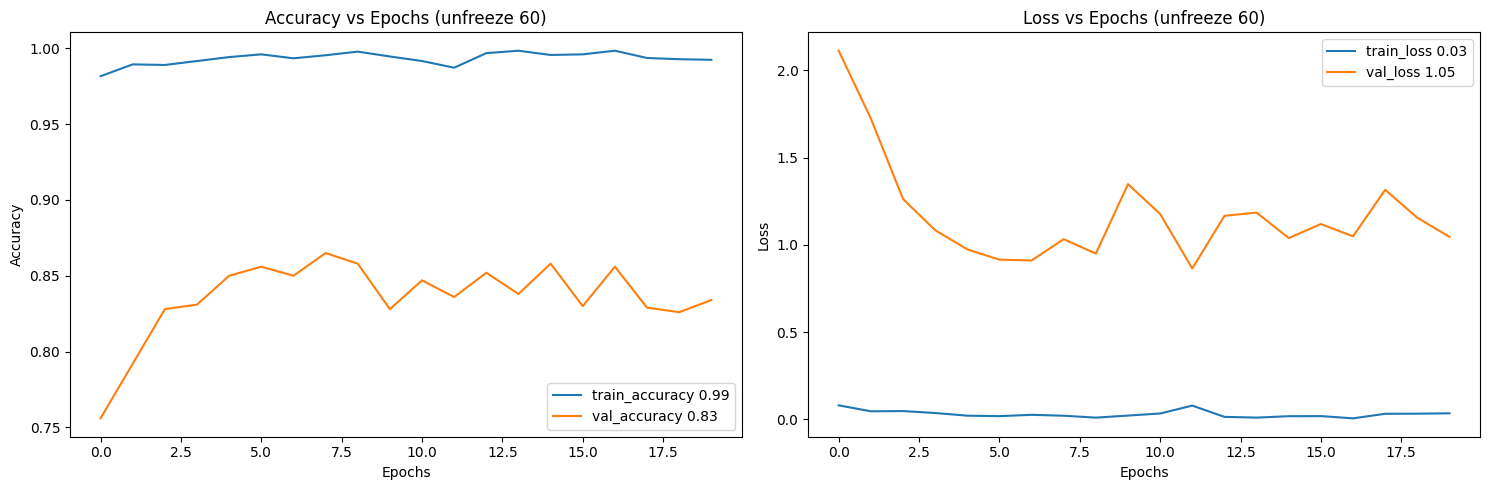

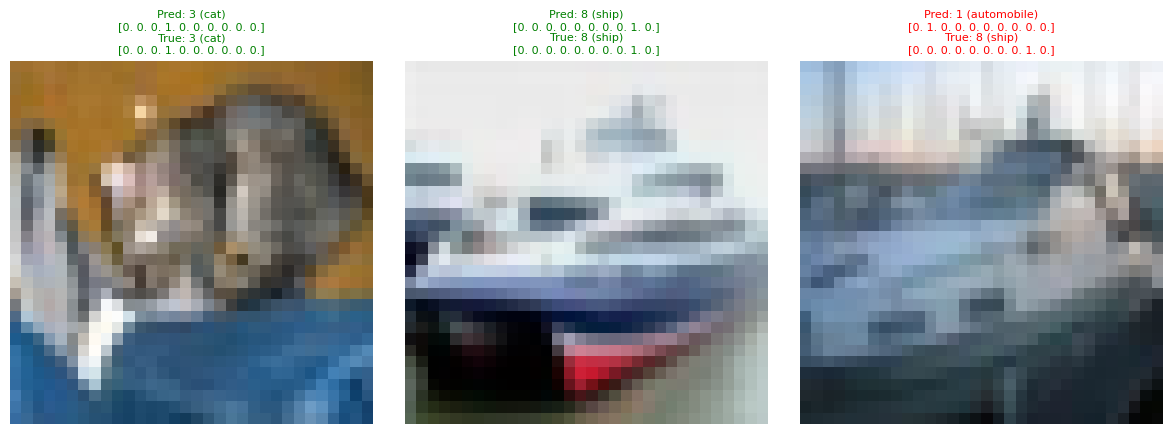


=== Unfreezing last 65 layers ===
Unfrozen: conv4_block3_3_bn (index 110)
Unfrozen: conv4_block3_add (index 111)
Unfrozen: conv4_block3_out (index 112)
Unfrozen: conv4_block4_1_conv (index 113)
Unfrozen: conv4_block4_1_bn (index 114)
Unfrozen: conv4_block4_1_relu (index 115)
Unfrozen: conv4_block4_2_conv (index 116)
Unfrozen: conv4_block4_2_bn (index 117)
Unfrozen: conv4_block4_2_relu (index 118)
Unfrozen: conv4_block4_3_conv (index 119)
Unfrozen: conv4_block4_3_bn (index 120)
Unfrozen: conv4_block4_add (index 121)
Unfrozen: conv4_block4_out (index 122)
Unfrozen: conv4_block5_1_conv (index 123)
Unfrozen: conv4_block5_1_bn (index 124)
Unfrozen: conv4_block5_1_relu (index 125)
Unfrozen: conv4_block5_2_conv (index 126)
Unfrozen: conv4_block5_2_bn (index 127)
Unfrozen: conv4_block5_2_relu (index 128)
Unfrozen: conv4_block5_3_conv (index 129)
Unfrozen: conv4_block5_3_bn (index 130)
Unfrozen: conv4_block5_add (index 131)
Unfrozen: conv4_block5_out (index 132)
Unfrozen: conv4_block6_1_conv (

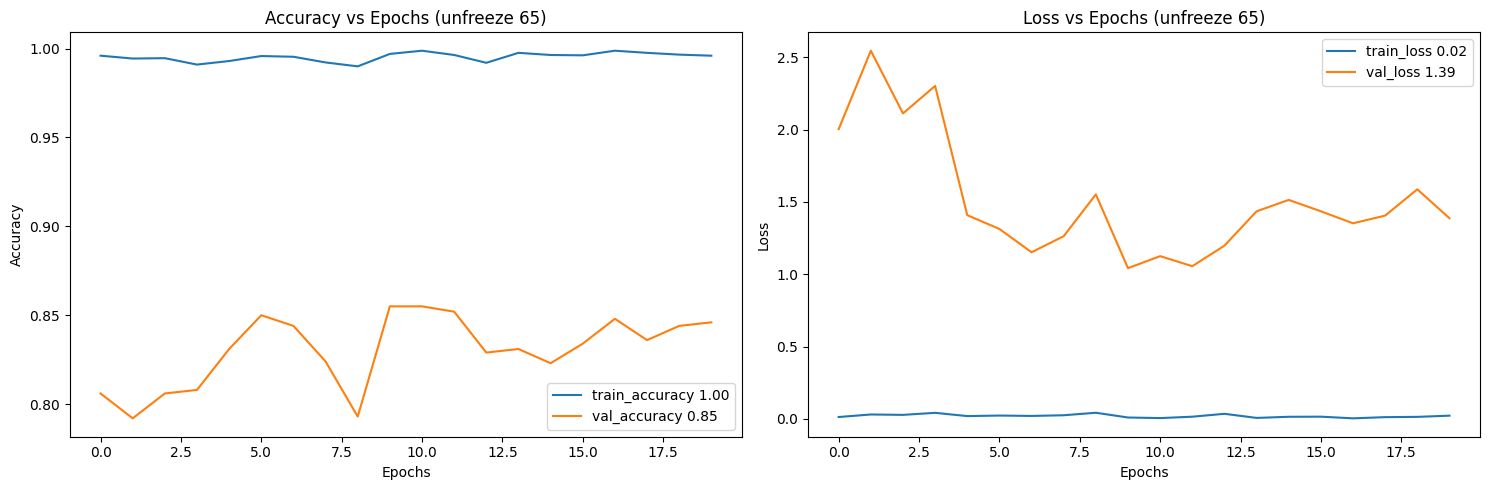

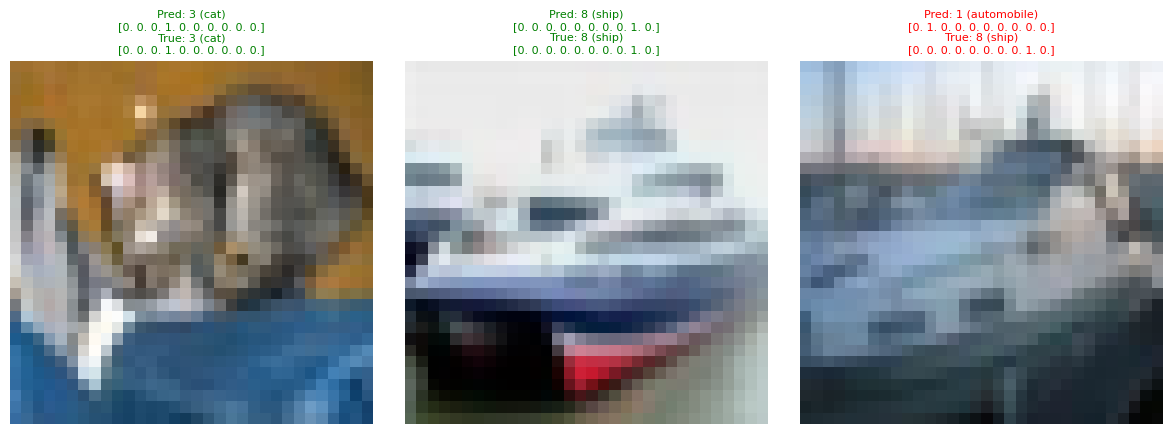


=== Unfreezing last 70 layers ===
Unfrozen: conv4_block3_1_relu (index 105)
Unfrozen: conv4_block3_2_conv (index 106)
Unfrozen: conv4_block3_2_bn (index 107)
Unfrozen: conv4_block3_2_relu (index 108)
Unfrozen: conv4_block3_3_conv (index 109)
Unfrozen: conv4_block3_3_bn (index 110)
Unfrozen: conv4_block3_add (index 111)
Unfrozen: conv4_block3_out (index 112)
Unfrozen: conv4_block4_1_conv (index 113)
Unfrozen: conv4_block4_1_bn (index 114)
Unfrozen: conv4_block4_1_relu (index 115)
Unfrozen: conv4_block4_2_conv (index 116)
Unfrozen: conv4_block4_2_bn (index 117)
Unfrozen: conv4_block4_2_relu (index 118)
Unfrozen: conv4_block4_3_conv (index 119)
Unfrozen: conv4_block4_3_bn (index 120)
Unfrozen: conv4_block4_add (index 121)
Unfrozen: conv4_block4_out (index 122)
Unfrozen: conv4_block5_1_conv (index 123)
Unfrozen: conv4_block5_1_bn (index 124)
Unfrozen: conv4_block5_1_relu (index 125)
Unfrozen: conv4_block5_2_conv (index 126)
Unfrozen: conv4_block5_2_bn (index 127)
Unfrozen: conv4_block5_2_

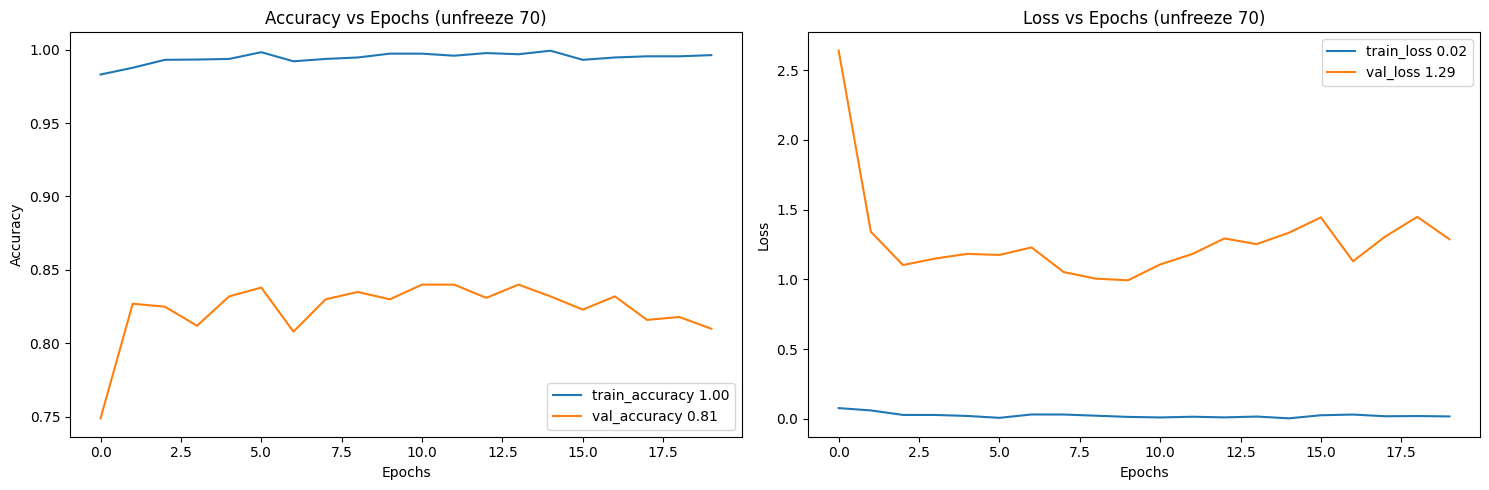

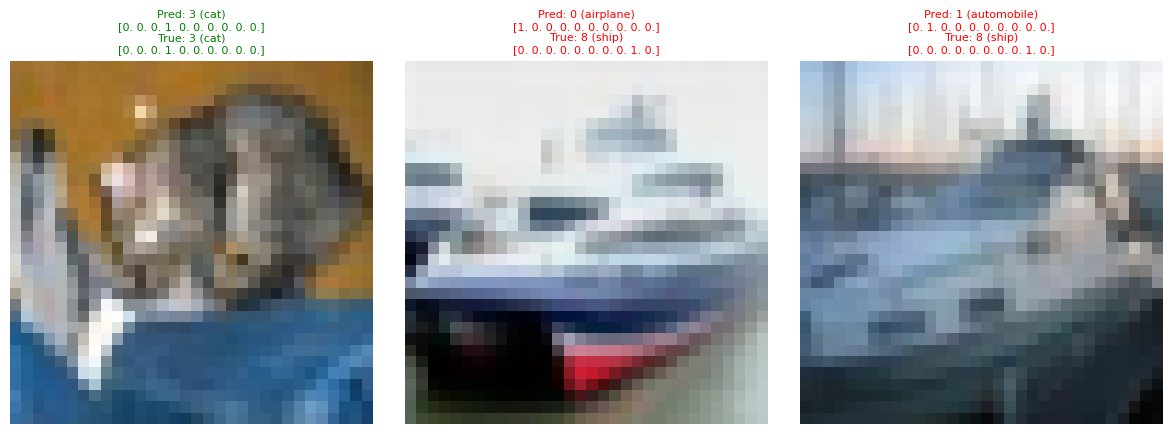


=== Unfreezing last 75 layers ===
Unfrozen: conv4_block2_3_bn (index 100)
Unfrozen: conv4_block2_add (index 101)
Unfrozen: conv4_block2_out (index 102)
Unfrozen: conv4_block3_1_conv (index 103)
Unfrozen: conv4_block3_1_bn (index 104)
Unfrozen: conv4_block3_1_relu (index 105)
Unfrozen: conv4_block3_2_conv (index 106)
Unfrozen: conv4_block3_2_bn (index 107)
Unfrozen: conv4_block3_2_relu (index 108)
Unfrozen: conv4_block3_3_conv (index 109)
Unfrozen: conv4_block3_3_bn (index 110)
Unfrozen: conv4_block3_add (index 111)
Unfrozen: conv4_block3_out (index 112)
Unfrozen: conv4_block4_1_conv (index 113)
Unfrozen: conv4_block4_1_bn (index 114)
Unfrozen: conv4_block4_1_relu (index 115)
Unfrozen: conv4_block4_2_conv (index 116)
Unfrozen: conv4_block4_2_bn (index 117)
Unfrozen: conv4_block4_2_relu (index 118)
Unfrozen: conv4_block4_3_conv (index 119)
Unfrozen: conv4_block4_3_bn (index 120)
Unfrozen: conv4_block4_add (index 121)
Unfrozen: conv4_block4_out (index 122)
Unfrozen: conv4_block5_1_conv (

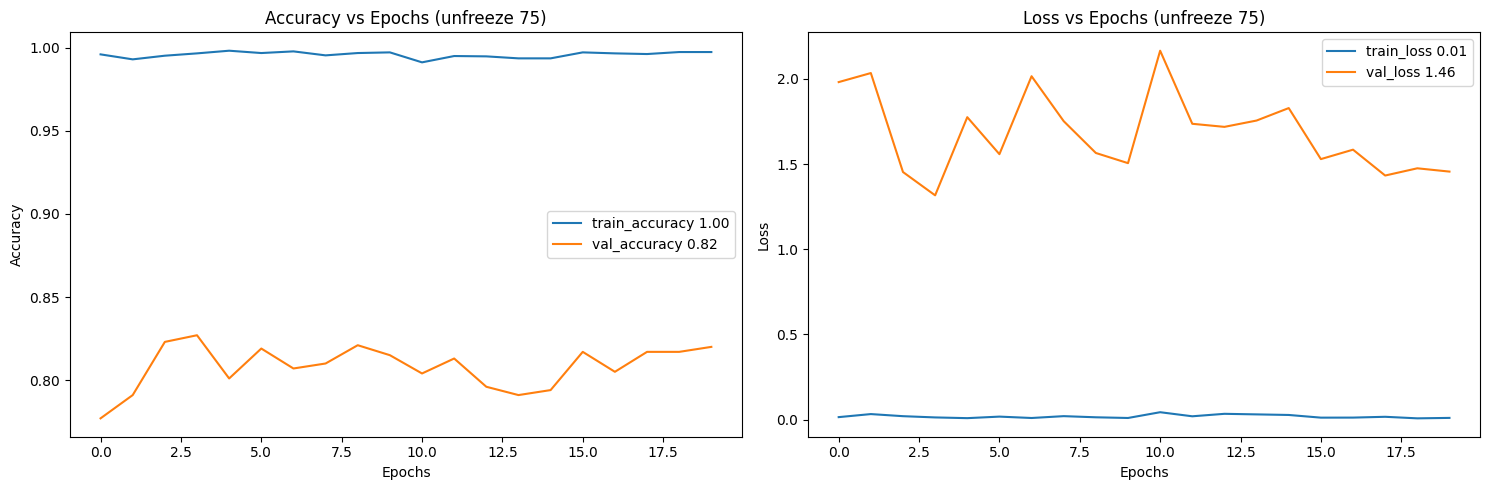

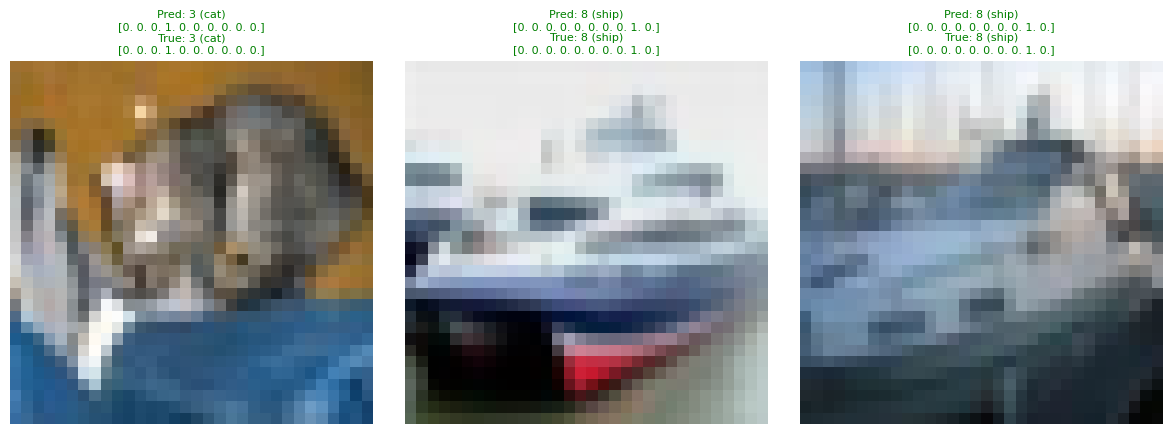


=== Unfreezing last 80 layers ===
Unfrozen: conv4_block2_1_relu (index 95)
Unfrozen: conv4_block2_2_conv (index 96)
Unfrozen: conv4_block2_2_bn (index 97)
Unfrozen: conv4_block2_2_relu (index 98)
Unfrozen: conv4_block2_3_conv (index 99)
Unfrozen: conv4_block2_3_bn (index 100)
Unfrozen: conv4_block2_add (index 101)
Unfrozen: conv4_block2_out (index 102)
Unfrozen: conv4_block3_1_conv (index 103)
Unfrozen: conv4_block3_1_bn (index 104)
Unfrozen: conv4_block3_1_relu (index 105)
Unfrozen: conv4_block3_2_conv (index 106)
Unfrozen: conv4_block3_2_bn (index 107)
Unfrozen: conv4_block3_2_relu (index 108)
Unfrozen: conv4_block3_3_conv (index 109)
Unfrozen: conv4_block3_3_bn (index 110)
Unfrozen: conv4_block3_add (index 111)
Unfrozen: conv4_block3_out (index 112)
Unfrozen: conv4_block4_1_conv (index 113)
Unfrozen: conv4_block4_1_bn (index 114)
Unfrozen: conv4_block4_1_relu (index 115)
Unfrozen: conv4_block4_2_conv (index 116)
Unfrozen: conv4_block4_2_bn (index 117)
Unfrozen: conv4_block4_2_relu 

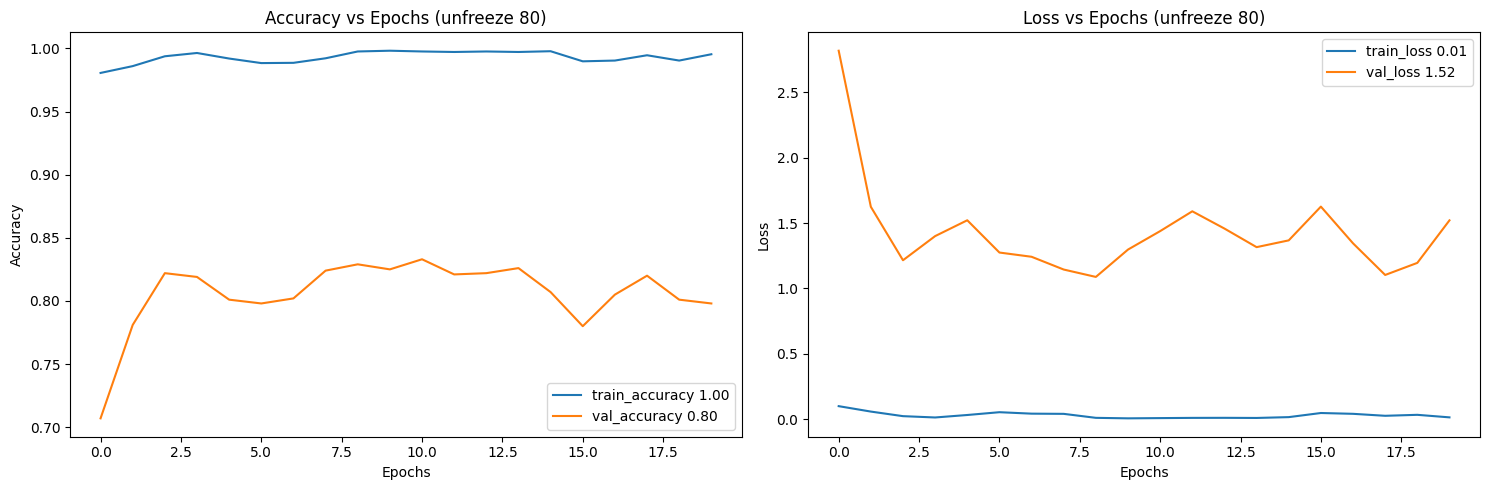

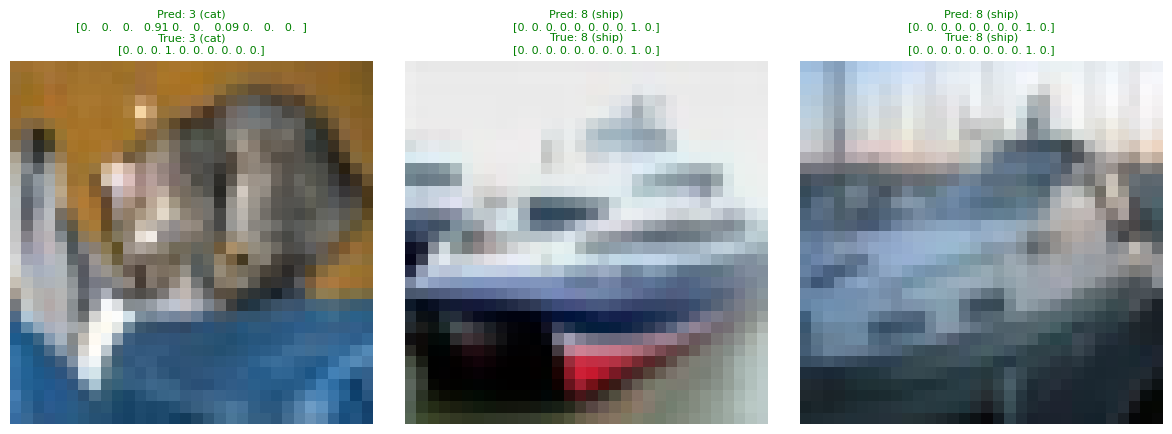


=== Unfreezing last 85 layers ===
Unfrozen: conv4_block1_3_bn (index 90)
Unfrozen: conv4_block1_add (index 91)
Unfrozen: conv4_block1_out (index 92)
Unfrozen: conv4_block2_1_conv (index 93)
Unfrozen: conv4_block2_1_bn (index 94)
Unfrozen: conv4_block2_1_relu (index 95)
Unfrozen: conv4_block2_2_conv (index 96)
Unfrozen: conv4_block2_2_bn (index 97)
Unfrozen: conv4_block2_2_relu (index 98)
Unfrozen: conv4_block2_3_conv (index 99)
Unfrozen: conv4_block2_3_bn (index 100)
Unfrozen: conv4_block2_add (index 101)
Unfrozen: conv4_block2_out (index 102)
Unfrozen: conv4_block3_1_conv (index 103)
Unfrozen: conv4_block3_1_bn (index 104)
Unfrozen: conv4_block3_1_relu (index 105)
Unfrozen: conv4_block3_2_conv (index 106)
Unfrozen: conv4_block3_2_bn (index 107)
Unfrozen: conv4_block3_2_relu (index 108)
Unfrozen: conv4_block3_3_conv (index 109)
Unfrozen: conv4_block3_3_bn (index 110)
Unfrozen: conv4_block3_add (index 111)
Unfrozen: conv4_block3_out (index 112)
Unfrozen: conv4_block4_1_conv (index 113)

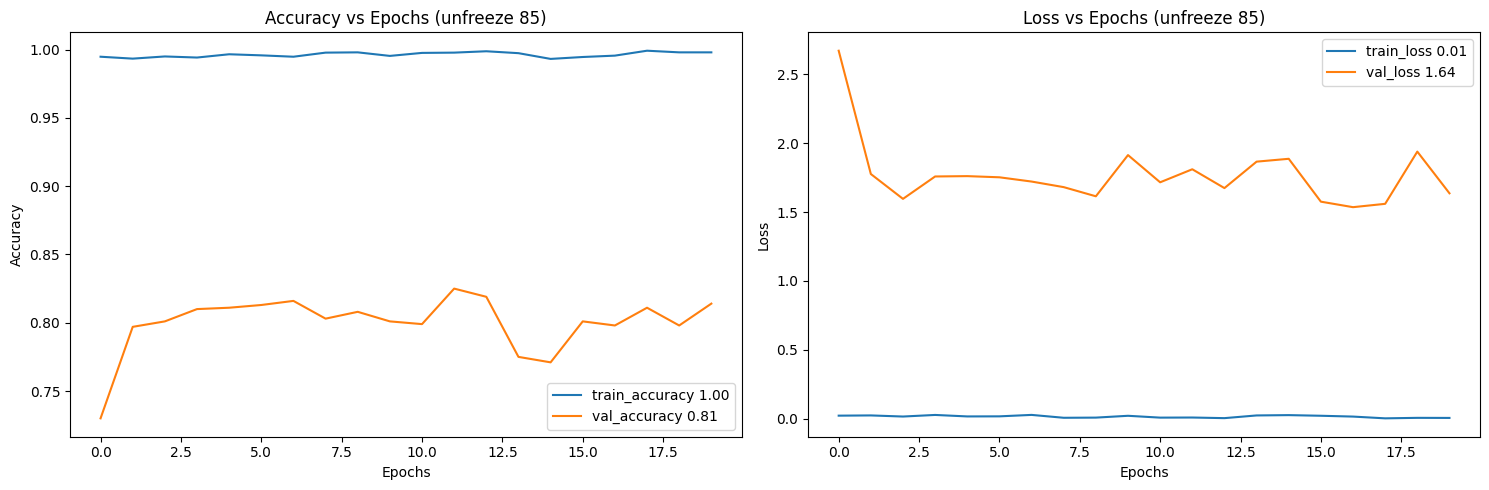

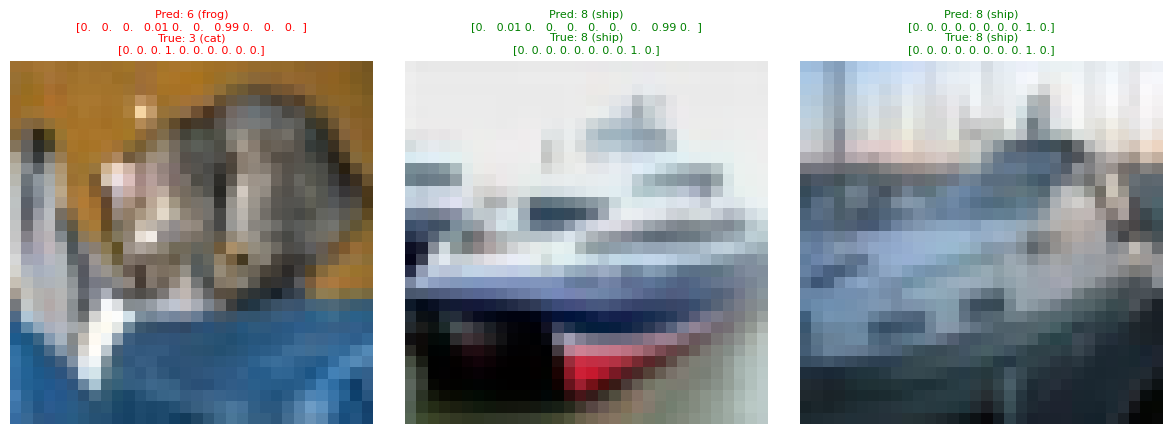


=== Unfreezing last 90 layers ===
Unfrozen: conv4_block1_2_bn (index 85)
Unfrozen: conv4_block1_2_relu (index 86)
Unfrozen: conv4_block1_0_conv (index 87)
Unfrozen: conv4_block1_3_conv (index 88)
Unfrozen: conv4_block1_0_bn (index 89)
Unfrozen: conv4_block1_3_bn (index 90)
Unfrozen: conv4_block1_add (index 91)
Unfrozen: conv4_block1_out (index 92)
Unfrozen: conv4_block2_1_conv (index 93)
Unfrozen: conv4_block2_1_bn (index 94)
Unfrozen: conv4_block2_1_relu (index 95)
Unfrozen: conv4_block2_2_conv (index 96)
Unfrozen: conv4_block2_2_bn (index 97)
Unfrozen: conv4_block2_2_relu (index 98)
Unfrozen: conv4_block2_3_conv (index 99)
Unfrozen: conv4_block2_3_bn (index 100)
Unfrozen: conv4_block2_add (index 101)
Unfrozen: conv4_block2_out (index 102)
Unfrozen: conv4_block3_1_conv (index 103)
Unfrozen: conv4_block3_1_bn (index 104)
Unfrozen: conv4_block3_1_relu (index 105)
Unfrozen: conv4_block3_2_conv (index 106)
Unfrozen: conv4_block3_2_bn (index 107)
Unfrozen: conv4_block3_2_relu (index 108)


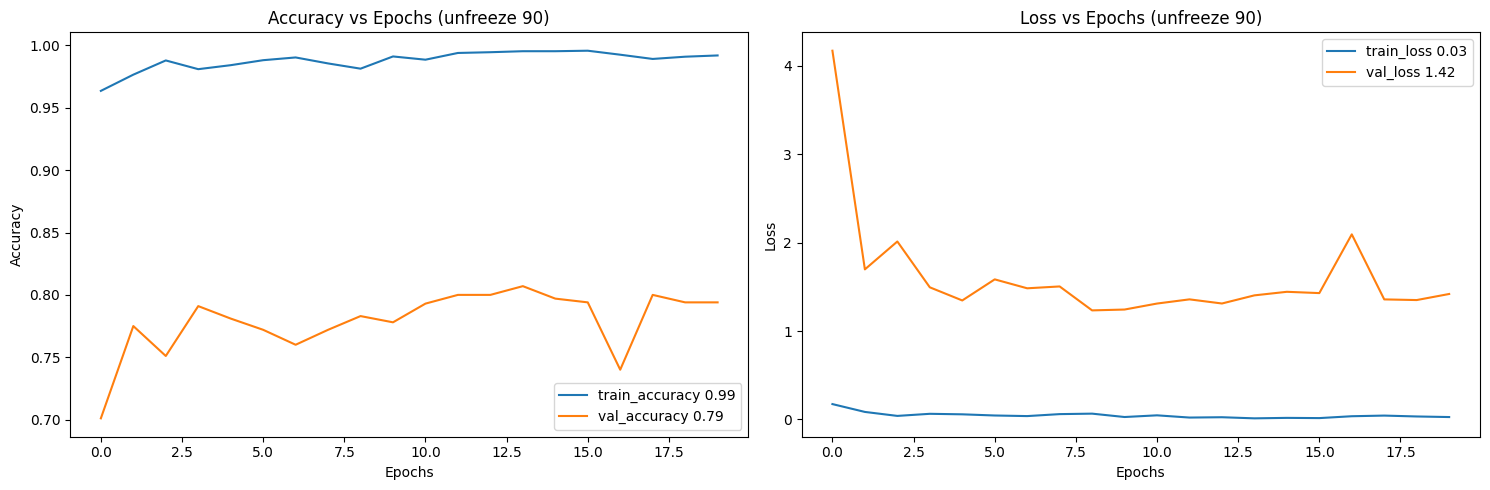

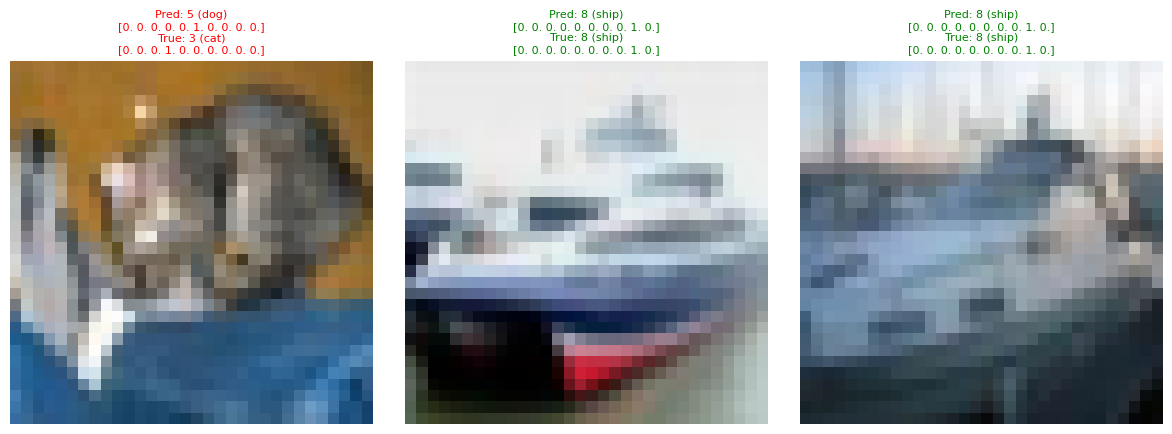


=== Unfreezing last 95 layers ===
Unfrozen: conv3_block4_out (index 80)
Unfrozen: conv4_block1_1_conv (index 81)
Unfrozen: conv4_block1_1_bn (index 82)
Unfrozen: conv4_block1_1_relu (index 83)
Unfrozen: conv4_block1_2_conv (index 84)
Unfrozen: conv4_block1_2_bn (index 85)
Unfrozen: conv4_block1_2_relu (index 86)
Unfrozen: conv4_block1_0_conv (index 87)
Unfrozen: conv4_block1_3_conv (index 88)
Unfrozen: conv4_block1_0_bn (index 89)
Unfrozen: conv4_block1_3_bn (index 90)
Unfrozen: conv4_block1_add (index 91)
Unfrozen: conv4_block1_out (index 92)
Unfrozen: conv4_block2_1_conv (index 93)
Unfrozen: conv4_block2_1_bn (index 94)
Unfrozen: conv4_block2_1_relu (index 95)
Unfrozen: conv4_block2_2_conv (index 96)
Unfrozen: conv4_block2_2_bn (index 97)
Unfrozen: conv4_block2_2_relu (index 98)
Unfrozen: conv4_block2_3_conv (index 99)
Unfrozen: conv4_block2_3_bn (index 100)
Unfrozen: conv4_block2_add (index 101)
Unfrozen: conv4_block2_out (index 102)
Unfrozen: conv4_block3_1_conv (index 103)
Unfroz

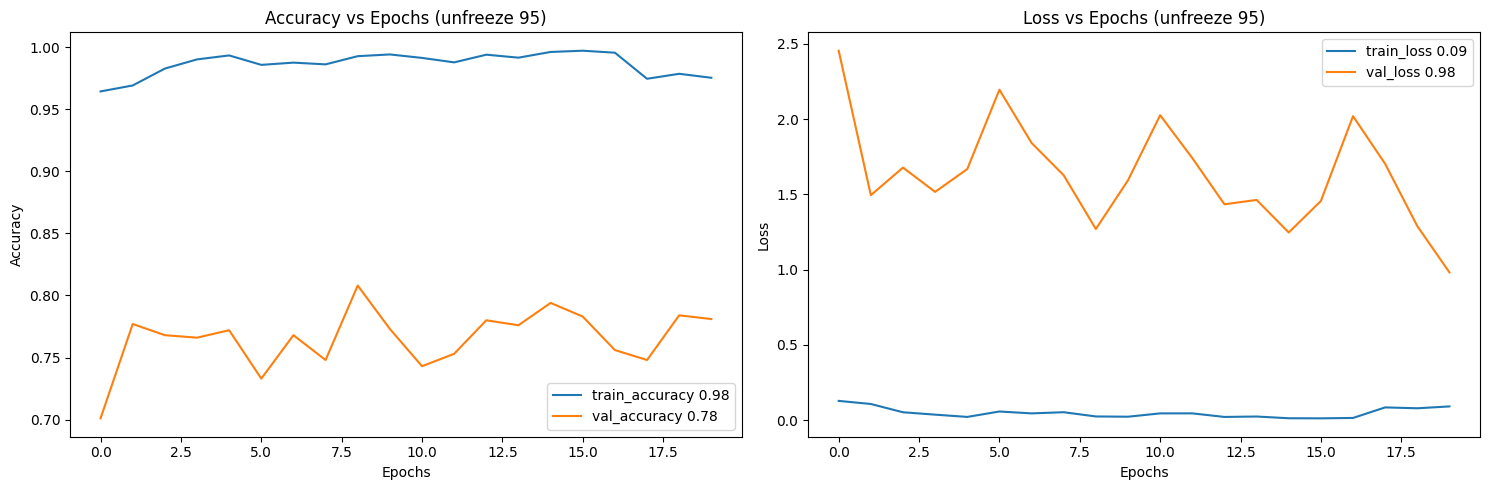

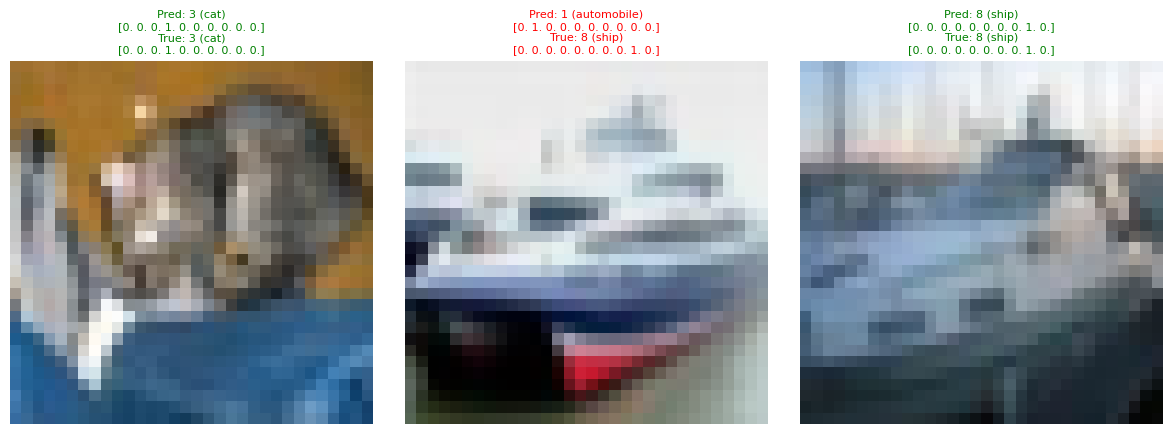


=== Unfreezing last 100 layers ===
Unfrozen: conv3_block4_2_bn (index 75)
Unfrozen: conv3_block4_2_relu (index 76)
Unfrozen: conv3_block4_3_conv (index 77)
Unfrozen: conv3_block4_3_bn (index 78)
Unfrozen: conv3_block4_add (index 79)
Unfrozen: conv3_block4_out (index 80)
Unfrozen: conv4_block1_1_conv (index 81)
Unfrozen: conv4_block1_1_bn (index 82)
Unfrozen: conv4_block1_1_relu (index 83)
Unfrozen: conv4_block1_2_conv (index 84)
Unfrozen: conv4_block1_2_bn (index 85)
Unfrozen: conv4_block1_2_relu (index 86)
Unfrozen: conv4_block1_0_conv (index 87)
Unfrozen: conv4_block1_3_conv (index 88)
Unfrozen: conv4_block1_0_bn (index 89)
Unfrozen: conv4_block1_3_bn (index 90)
Unfrozen: conv4_block1_add (index 91)
Unfrozen: conv4_block1_out (index 92)
Unfrozen: conv4_block2_1_conv (index 93)
Unfrozen: conv4_block2_1_bn (index 94)
Unfrozen: conv4_block2_1_relu (index 95)
Unfrozen: conv4_block2_2_conv (index 96)
Unfrozen: conv4_block2_2_bn (index 97)
Unfrozen: conv4_block2_2_relu (index 98)
Unfrozen

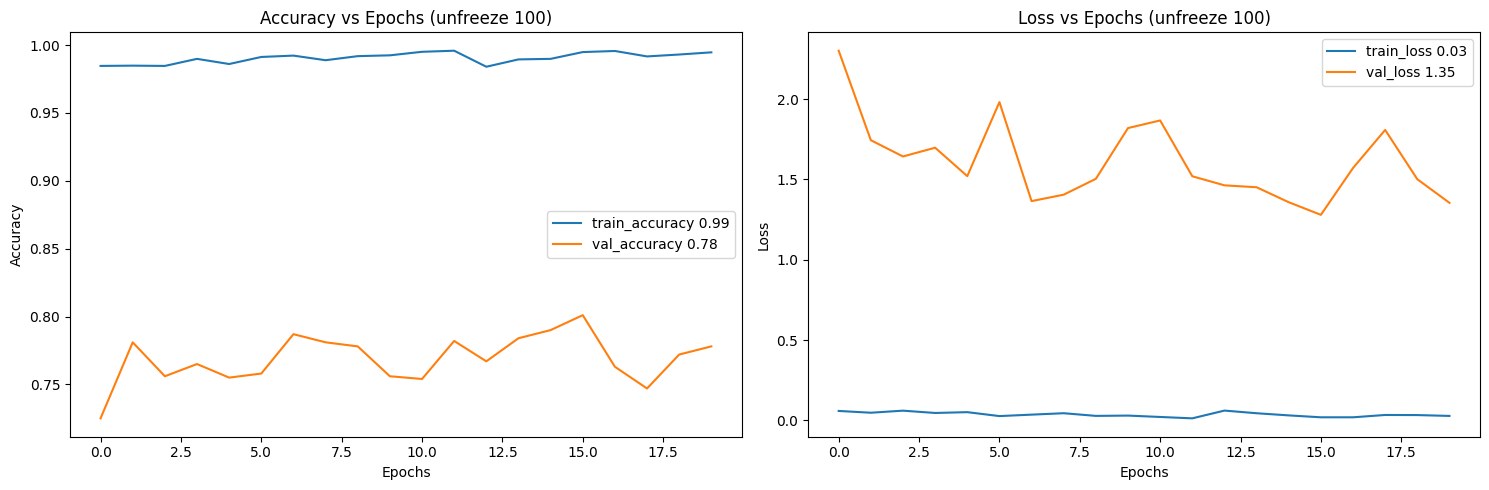

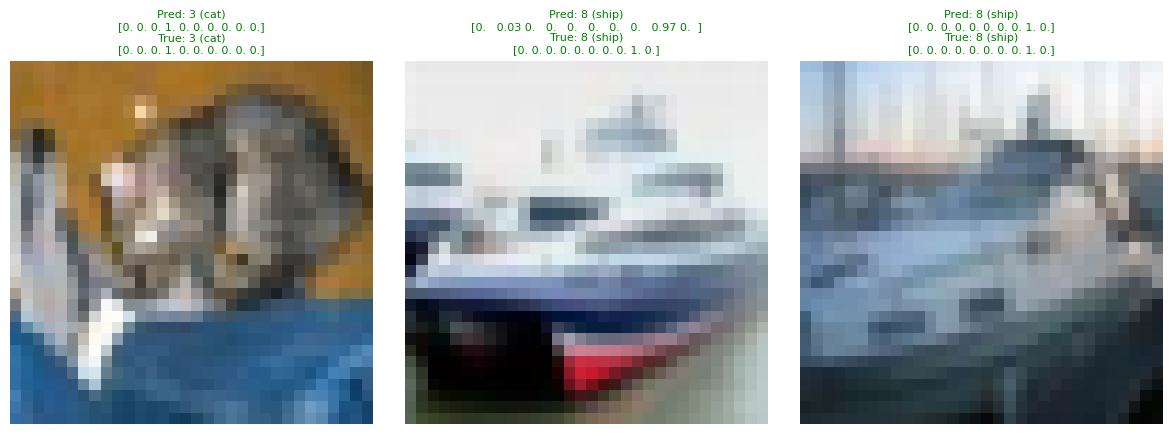


=== Unfreezing last 105 layers ===
Unfrozen: conv3_block3_out (index 70)
Unfrozen: conv3_block4_1_conv (index 71)
Unfrozen: conv3_block4_1_bn (index 72)
Unfrozen: conv3_block4_1_relu (index 73)
Unfrozen: conv3_block4_2_conv (index 74)
Unfrozen: conv3_block4_2_bn (index 75)
Unfrozen: conv3_block4_2_relu (index 76)
Unfrozen: conv3_block4_3_conv (index 77)
Unfrozen: conv3_block4_3_bn (index 78)
Unfrozen: conv3_block4_add (index 79)
Unfrozen: conv3_block4_out (index 80)
Unfrozen: conv4_block1_1_conv (index 81)
Unfrozen: conv4_block1_1_bn (index 82)
Unfrozen: conv4_block1_1_relu (index 83)
Unfrozen: conv4_block1_2_conv (index 84)
Unfrozen: conv4_block1_2_bn (index 85)
Unfrozen: conv4_block1_2_relu (index 86)
Unfrozen: conv4_block1_0_conv (index 87)
Unfrozen: conv4_block1_3_conv (index 88)
Unfrozen: conv4_block1_0_bn (index 89)
Unfrozen: conv4_block1_3_bn (index 90)
Unfrozen: conv4_block1_add (index 91)
Unfrozen: conv4_block1_out (index 92)
Unfrozen: conv4_block2_1_conv (index 93)
Unfrozen:

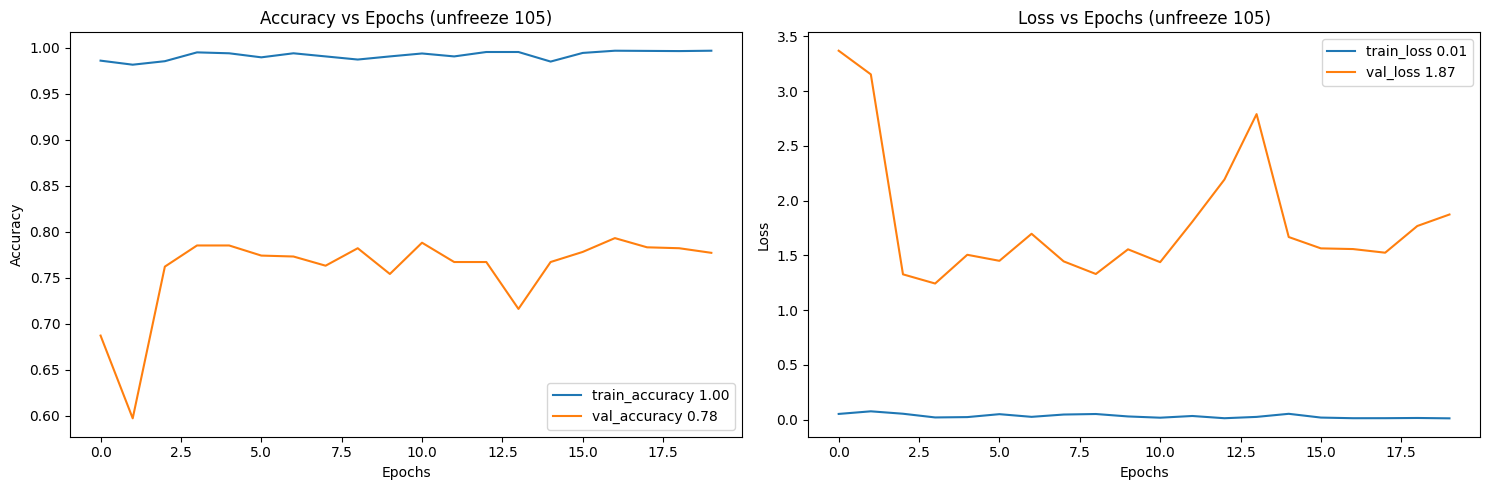

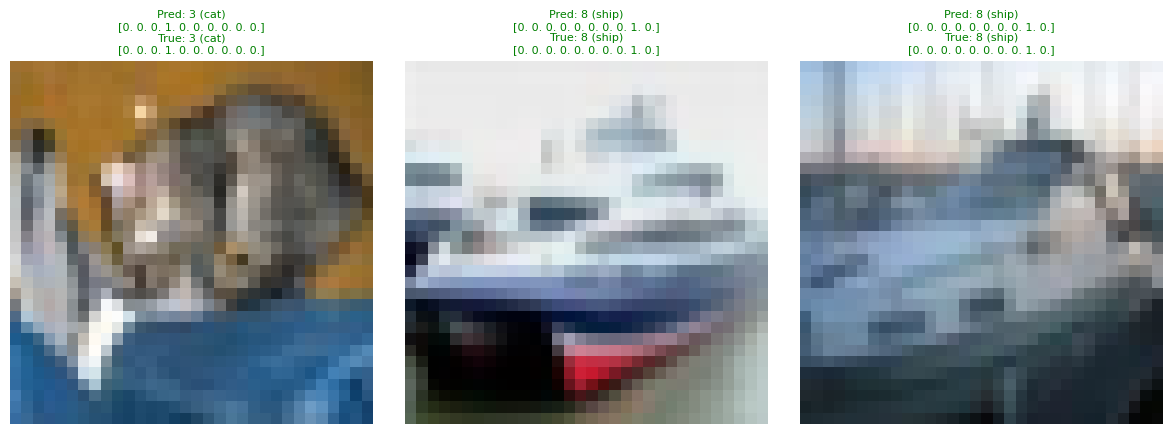


=== Unfreezing last 110 layers ===
Unfrozen: conv3_block3_2_bn (index 65)
Unfrozen: conv3_block3_2_relu (index 66)
Unfrozen: conv3_block3_3_conv (index 67)
Unfrozen: conv3_block3_3_bn (index 68)
Unfrozen: conv3_block3_add (index 69)
Unfrozen: conv3_block3_out (index 70)
Unfrozen: conv3_block4_1_conv (index 71)
Unfrozen: conv3_block4_1_bn (index 72)
Unfrozen: conv3_block4_1_relu (index 73)
Unfrozen: conv3_block4_2_conv (index 74)
Unfrozen: conv3_block4_2_bn (index 75)
Unfrozen: conv3_block4_2_relu (index 76)
Unfrozen: conv3_block4_3_conv (index 77)
Unfrozen: conv3_block4_3_bn (index 78)
Unfrozen: conv3_block4_add (index 79)
Unfrozen: conv3_block4_out (index 80)
Unfrozen: conv4_block1_1_conv (index 81)
Unfrozen: conv4_block1_1_bn (index 82)
Unfrozen: conv4_block1_1_relu (index 83)
Unfrozen: conv4_block1_2_conv (index 84)
Unfrozen: conv4_block1_2_bn (index 85)
Unfrozen: conv4_block1_2_relu (index 86)
Unfrozen: conv4_block1_0_conv (index 87)
Unfrozen: conv4_block1_3_conv (index 88)
Unfroz

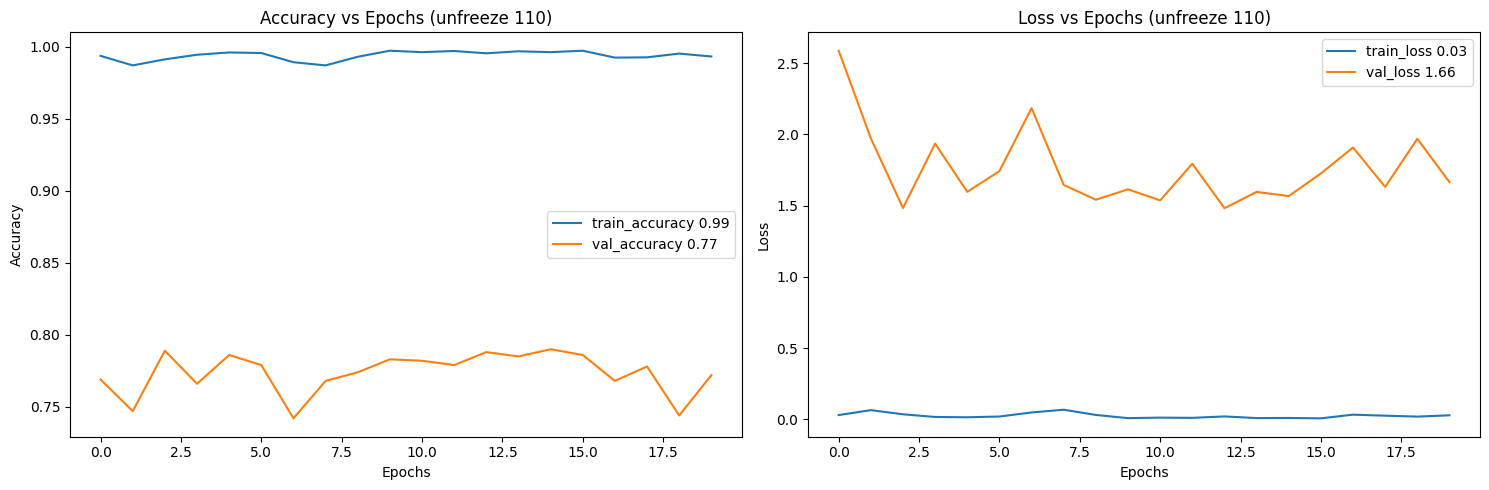

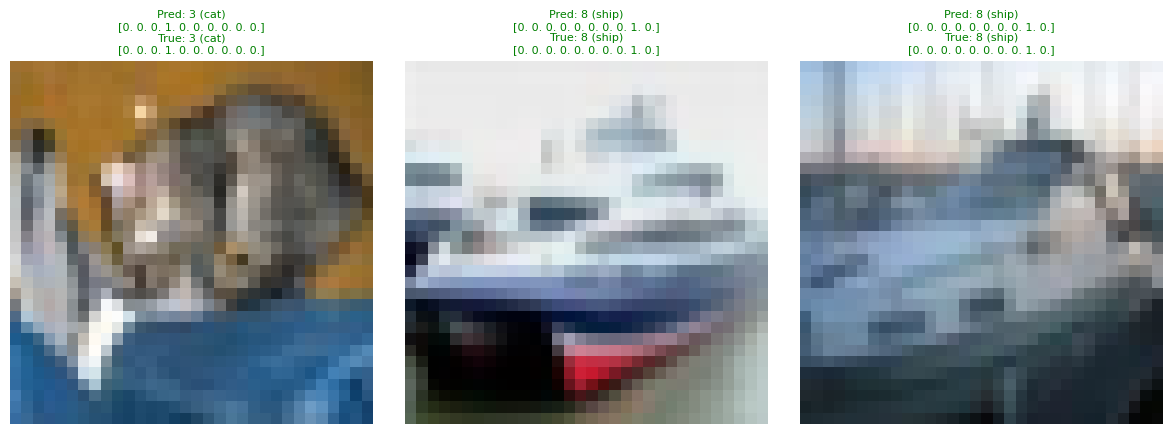


=== Unfreezing last 115 layers ===
Unfrozen: conv3_block2_out (index 60)
Unfrozen: conv3_block3_1_conv (index 61)
Unfrozen: conv3_block3_1_bn (index 62)
Unfrozen: conv3_block3_1_relu (index 63)
Unfrozen: conv3_block3_2_conv (index 64)
Unfrozen: conv3_block3_2_bn (index 65)
Unfrozen: conv3_block3_2_relu (index 66)
Unfrozen: conv3_block3_3_conv (index 67)
Unfrozen: conv3_block3_3_bn (index 68)
Unfrozen: conv3_block3_add (index 69)
Unfrozen: conv3_block3_out (index 70)
Unfrozen: conv3_block4_1_conv (index 71)
Unfrozen: conv3_block4_1_bn (index 72)
Unfrozen: conv3_block4_1_relu (index 73)
Unfrozen: conv3_block4_2_conv (index 74)
Unfrozen: conv3_block4_2_bn (index 75)
Unfrozen: conv3_block4_2_relu (index 76)
Unfrozen: conv3_block4_3_conv (index 77)
Unfrozen: conv3_block4_3_bn (index 78)
Unfrozen: conv3_block4_add (index 79)
Unfrozen: conv3_block4_out (index 80)
Unfrozen: conv4_block1_1_conv (index 81)
Unfrozen: conv4_block1_1_bn (index 82)
Unfrozen: conv4_block1_1_relu (index 83)
Unfrozen:

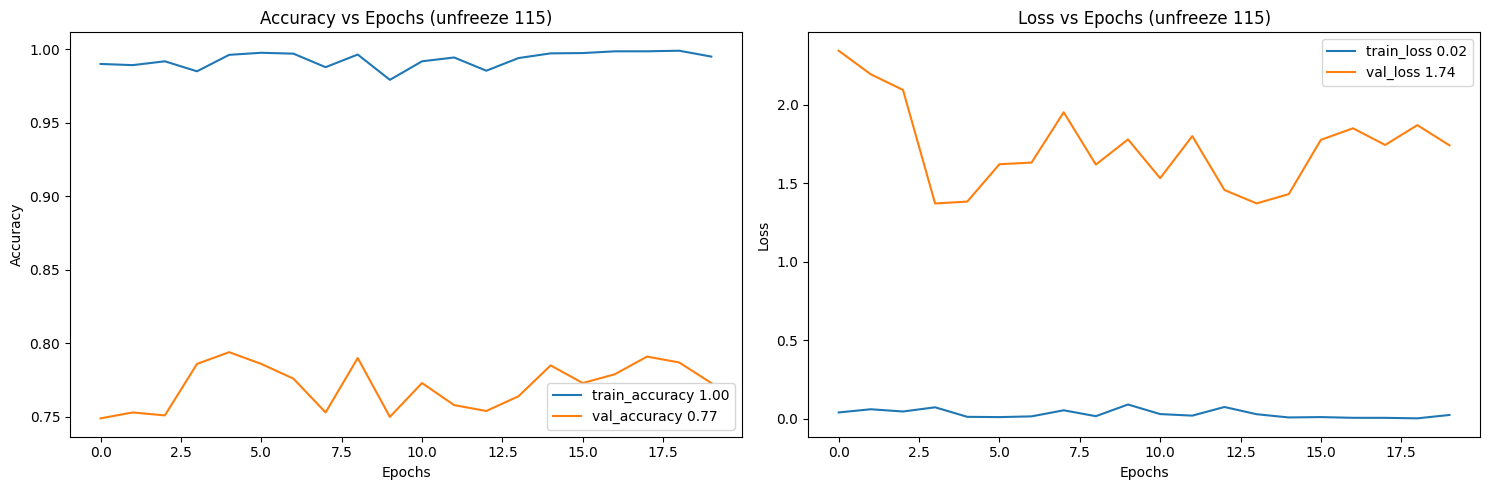

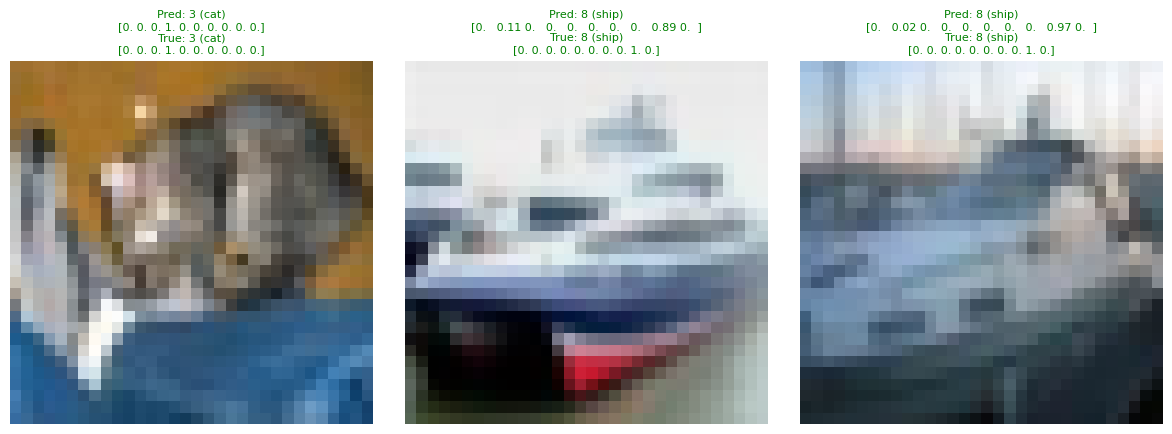


=== Unfreezing last 120 layers ===
Unfrozen: conv3_block2_2_bn (index 55)
Unfrozen: conv3_block2_2_relu (index 56)
Unfrozen: conv3_block2_3_conv (index 57)
Unfrozen: conv3_block2_3_bn (index 58)
Unfrozen: conv3_block2_add (index 59)
Unfrozen: conv3_block2_out (index 60)
Unfrozen: conv3_block3_1_conv (index 61)
Unfrozen: conv3_block3_1_bn (index 62)
Unfrozen: conv3_block3_1_relu (index 63)
Unfrozen: conv3_block3_2_conv (index 64)
Unfrozen: conv3_block3_2_bn (index 65)
Unfrozen: conv3_block3_2_relu (index 66)
Unfrozen: conv3_block3_3_conv (index 67)
Unfrozen: conv3_block3_3_bn (index 68)
Unfrozen: conv3_block3_add (index 69)
Unfrozen: conv3_block3_out (index 70)
Unfrozen: conv3_block4_1_conv (index 71)
Unfrozen: conv3_block4_1_bn (index 72)
Unfrozen: conv3_block4_1_relu (index 73)
Unfrozen: conv3_block4_2_conv (index 74)
Unfrozen: conv3_block4_2_bn (index 75)
Unfrozen: conv3_block4_2_relu (index 76)
Unfrozen: conv3_block4_3_conv (index 77)
Unfrozen: conv3_block4_3_bn (index 78)
Unfrozen

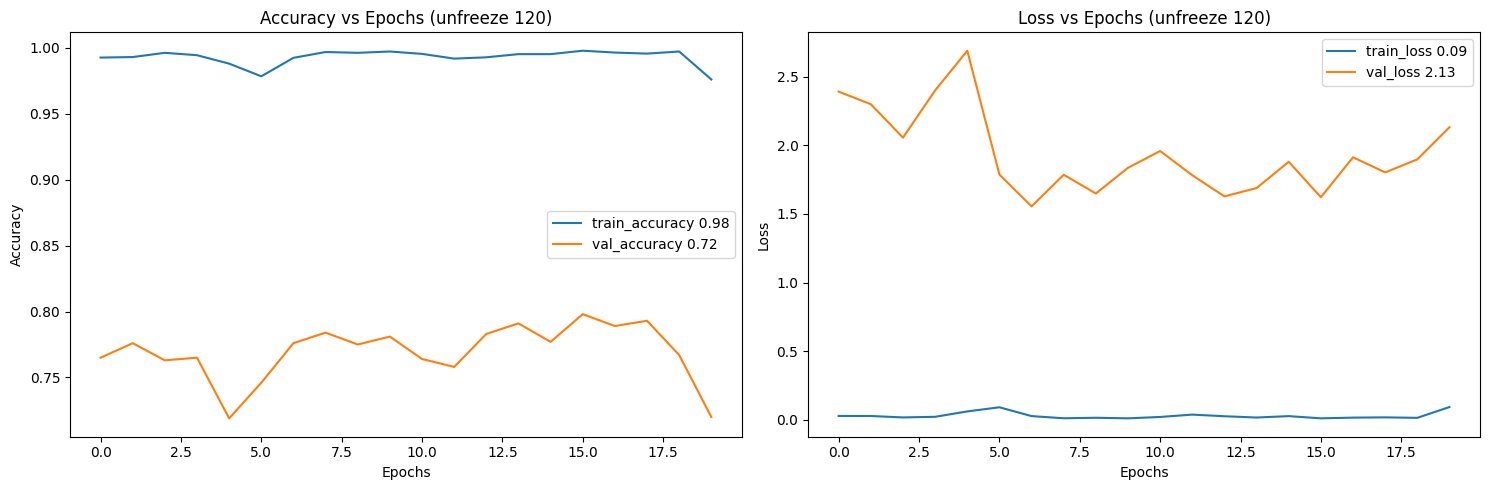

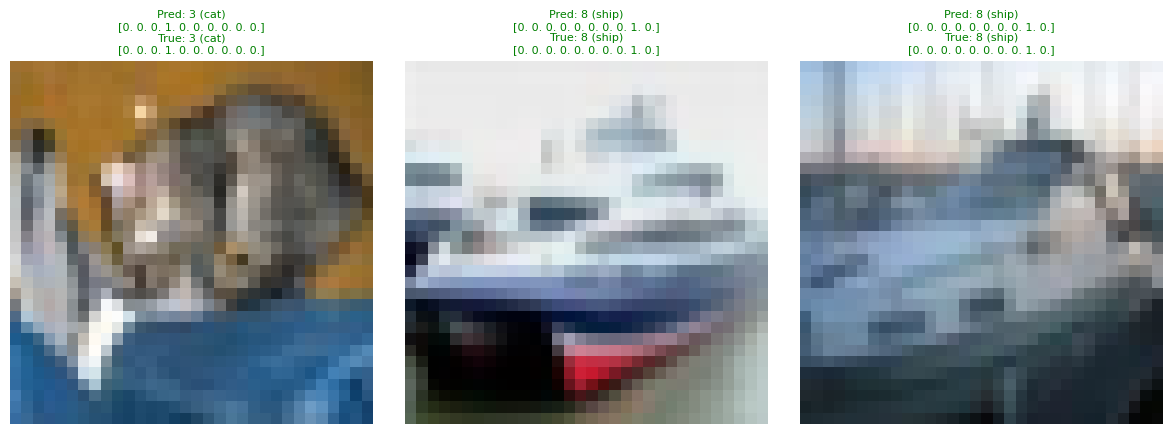


=== Unfreezing last 125 layers ===
Unfrozen: conv3_block1_out (index 50)
Unfrozen: conv3_block2_1_conv (index 51)
Unfrozen: conv3_block2_1_bn (index 52)
Unfrozen: conv3_block2_1_relu (index 53)
Unfrozen: conv3_block2_2_conv (index 54)
Unfrozen: conv3_block2_2_bn (index 55)
Unfrozen: conv3_block2_2_relu (index 56)
Unfrozen: conv3_block2_3_conv (index 57)
Unfrozen: conv3_block2_3_bn (index 58)
Unfrozen: conv3_block2_add (index 59)
Unfrozen: conv3_block2_out (index 60)
Unfrozen: conv3_block3_1_conv (index 61)
Unfrozen: conv3_block3_1_bn (index 62)
Unfrozen: conv3_block3_1_relu (index 63)
Unfrozen: conv3_block3_2_conv (index 64)
Unfrozen: conv3_block3_2_bn (index 65)
Unfrozen: conv3_block3_2_relu (index 66)
Unfrozen: conv3_block3_3_conv (index 67)
Unfrozen: conv3_block3_3_bn (index 68)
Unfrozen: conv3_block3_add (index 69)
Unfrozen: conv3_block3_out (index 70)
Unfrozen: conv3_block4_1_conv (index 71)
Unfrozen: conv3_block4_1_bn (index 72)
Unfrozen: conv3_block4_1_relu (index 73)
Unfrozen:

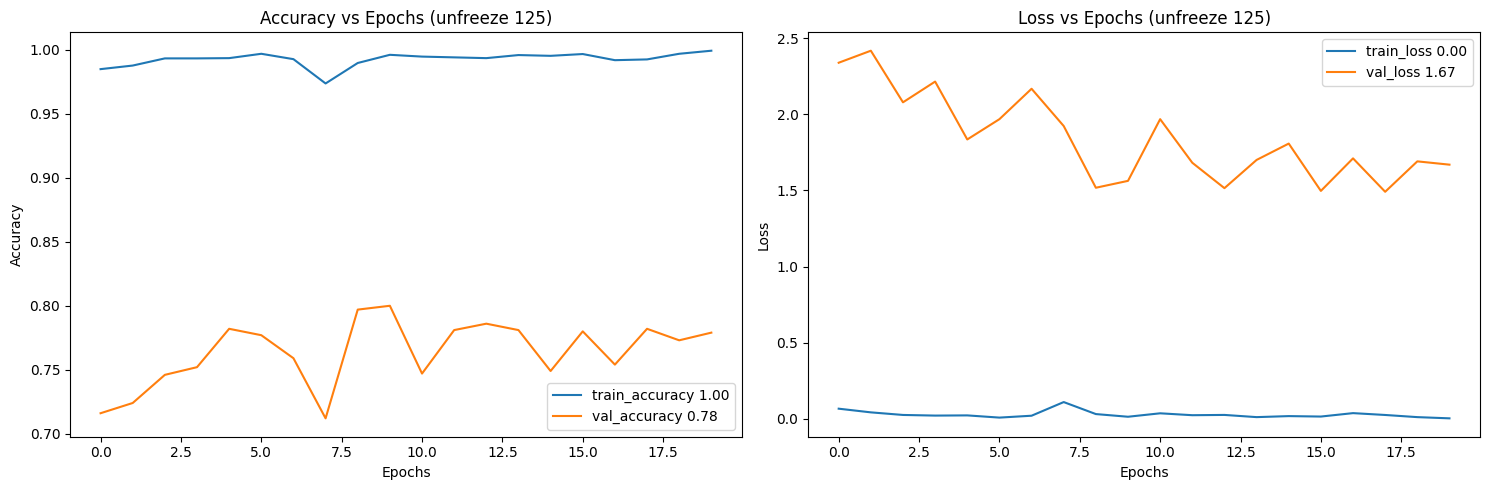

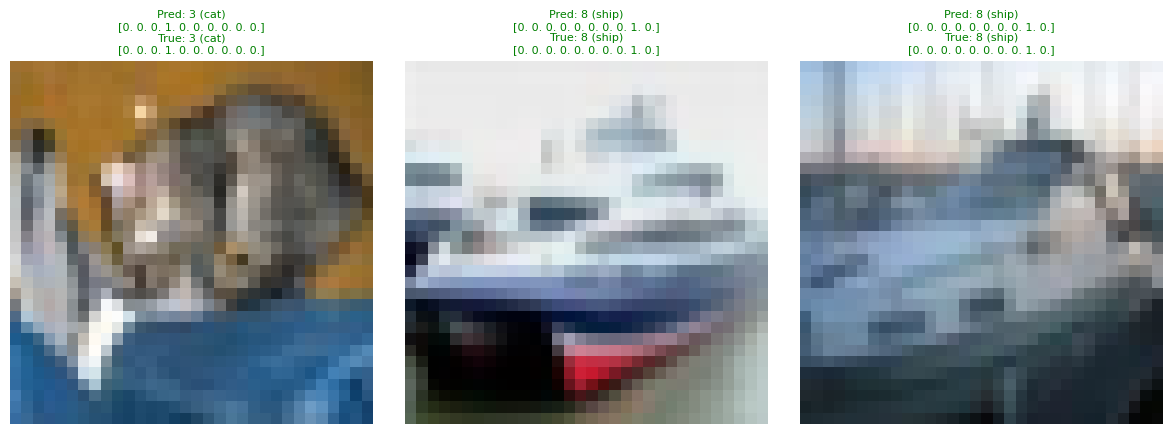


=== Unfreezing last 130 layers ===
Unfrozen: conv3_block1_0_conv (index 45)
Unfrozen: conv3_block1_3_conv (index 46)
Unfrozen: conv3_block1_0_bn (index 47)
Unfrozen: conv3_block1_3_bn (index 48)
Unfrozen: conv3_block1_add (index 49)
Unfrozen: conv3_block1_out (index 50)
Unfrozen: conv3_block2_1_conv (index 51)
Unfrozen: conv3_block2_1_bn (index 52)
Unfrozen: conv3_block2_1_relu (index 53)
Unfrozen: conv3_block2_2_conv (index 54)
Unfrozen: conv3_block2_2_bn (index 55)
Unfrozen: conv3_block2_2_relu (index 56)
Unfrozen: conv3_block2_3_conv (index 57)
Unfrozen: conv3_block2_3_bn (index 58)
Unfrozen: conv3_block2_add (index 59)
Unfrozen: conv3_block2_out (index 60)
Unfrozen: conv3_block3_1_conv (index 61)
Unfrozen: conv3_block3_1_bn (index 62)
Unfrozen: conv3_block3_1_relu (index 63)
Unfrozen: conv3_block3_2_conv (index 64)
Unfrozen: conv3_block3_2_bn (index 65)
Unfrozen: conv3_block3_2_relu (index 66)
Unfrozen: conv3_block3_3_conv (index 67)
Unfrozen: conv3_block3_3_bn (index 68)
Unfrozen

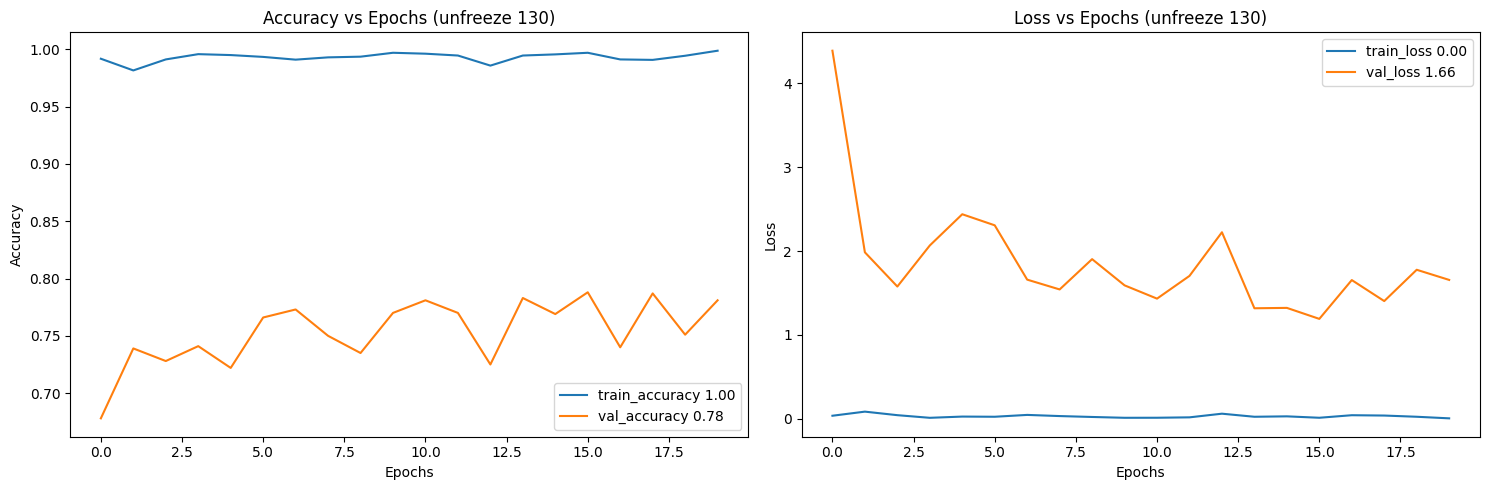

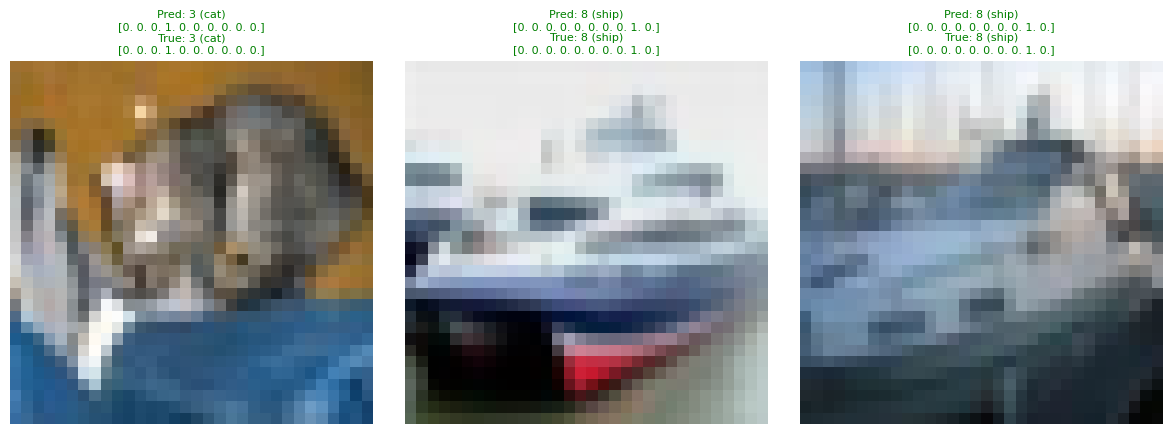


=== Unfreezing last 135 layers ===
Unfrozen: conv3_block1_1_bn (index 40)
Unfrozen: conv3_block1_1_relu (index 41)
Unfrozen: conv3_block1_2_conv (index 42)
Unfrozen: conv3_block1_2_bn (index 43)
Unfrozen: conv3_block1_2_relu (index 44)
Unfrozen: conv3_block1_0_conv (index 45)
Unfrozen: conv3_block1_3_conv (index 46)
Unfrozen: conv3_block1_0_bn (index 47)
Unfrozen: conv3_block1_3_bn (index 48)
Unfrozen: conv3_block1_add (index 49)
Unfrozen: conv3_block1_out (index 50)
Unfrozen: conv3_block2_1_conv (index 51)
Unfrozen: conv3_block2_1_bn (index 52)
Unfrozen: conv3_block2_1_relu (index 53)
Unfrozen: conv3_block2_2_conv (index 54)
Unfrozen: conv3_block2_2_bn (index 55)
Unfrozen: conv3_block2_2_relu (index 56)
Unfrozen: conv3_block2_3_conv (index 57)
Unfrozen: conv3_block2_3_bn (index 58)
Unfrozen: conv3_block2_add (index 59)
Unfrozen: conv3_block2_out (index 60)
Unfrozen: conv3_block3_1_conv (index 61)
Unfrozen: conv3_block3_1_bn (index 62)
Unfrozen: conv3_block3_1_relu (index 63)
Unfrozen

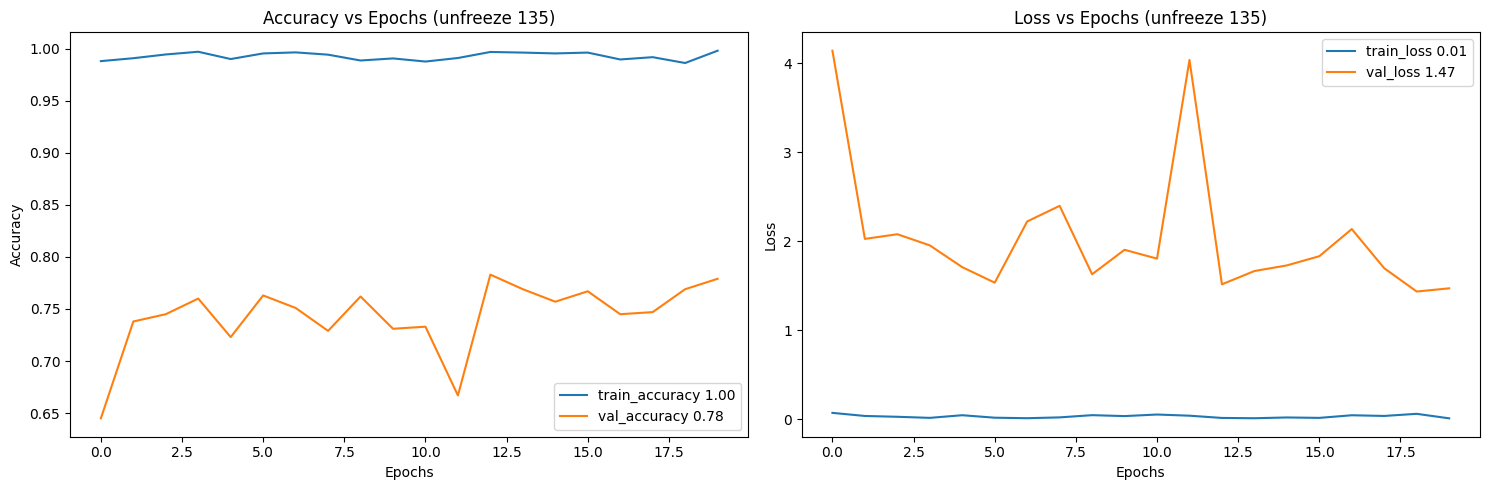

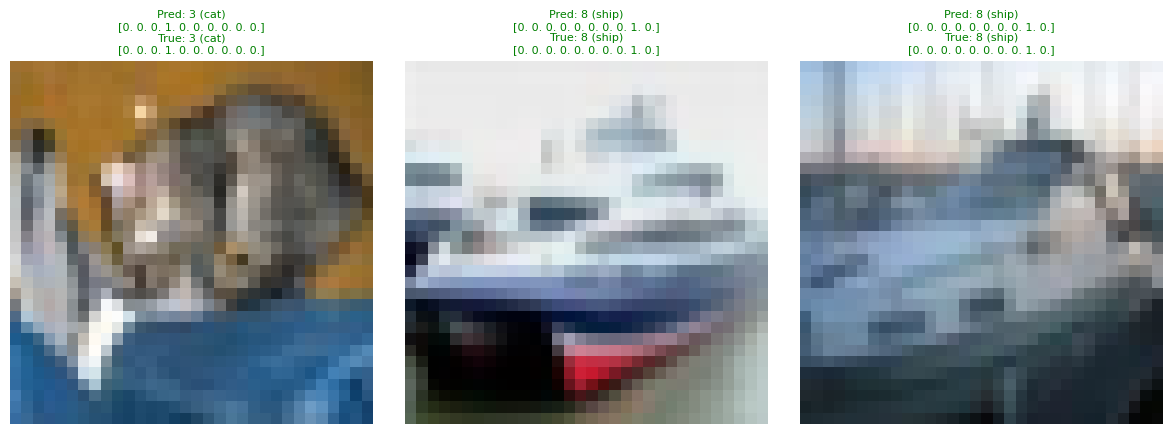


=== Unfreezing last 140 layers ===
Unfrozen: conv2_block3_3_conv (index 35)
Unfrozen: conv2_block3_3_bn (index 36)
Unfrozen: conv2_block3_add (index 37)
Unfrozen: conv2_block3_out (index 38)
Unfrozen: conv3_block1_1_conv (index 39)
Unfrozen: conv3_block1_1_bn (index 40)
Unfrozen: conv3_block1_1_relu (index 41)
Unfrozen: conv3_block1_2_conv (index 42)
Unfrozen: conv3_block1_2_bn (index 43)
Unfrozen: conv3_block1_2_relu (index 44)
Unfrozen: conv3_block1_0_conv (index 45)
Unfrozen: conv3_block1_3_conv (index 46)
Unfrozen: conv3_block1_0_bn (index 47)
Unfrozen: conv3_block1_3_bn (index 48)
Unfrozen: conv3_block1_add (index 49)
Unfrozen: conv3_block1_out (index 50)
Unfrozen: conv3_block2_1_conv (index 51)
Unfrozen: conv3_block2_1_bn (index 52)
Unfrozen: conv3_block2_1_relu (index 53)
Unfrozen: conv3_block2_2_conv (index 54)
Unfrozen: conv3_block2_2_bn (index 55)
Unfrozen: conv3_block2_2_relu (index 56)
Unfrozen: conv3_block2_3_conv (index 57)
Unfrozen: conv3_block2_3_bn (index 58)
Unfrozen

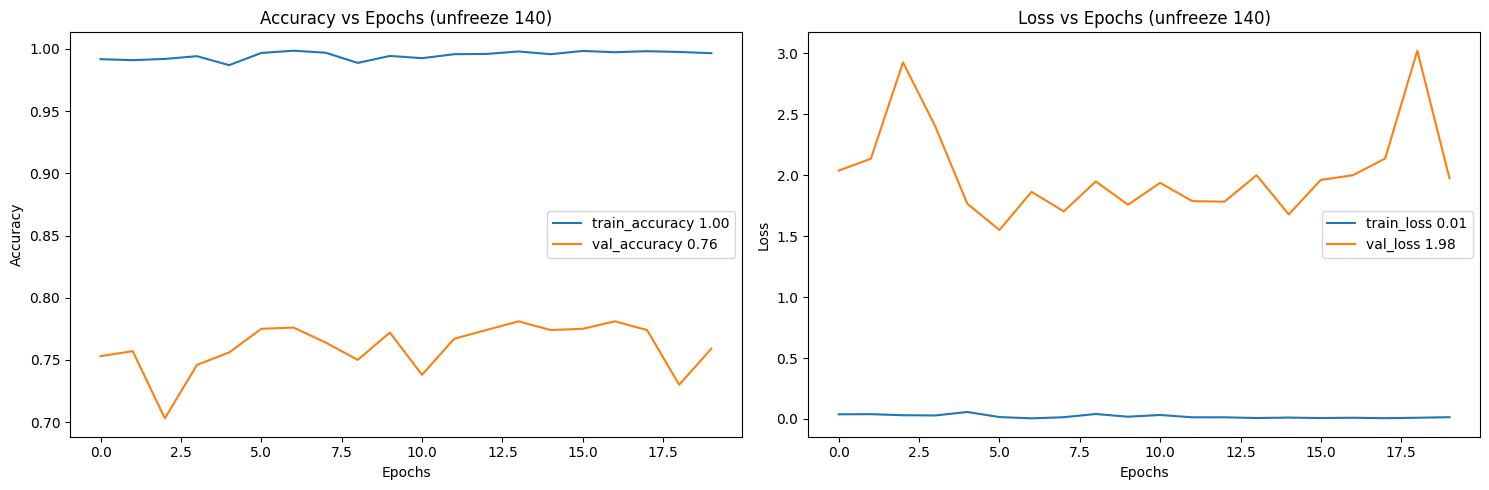

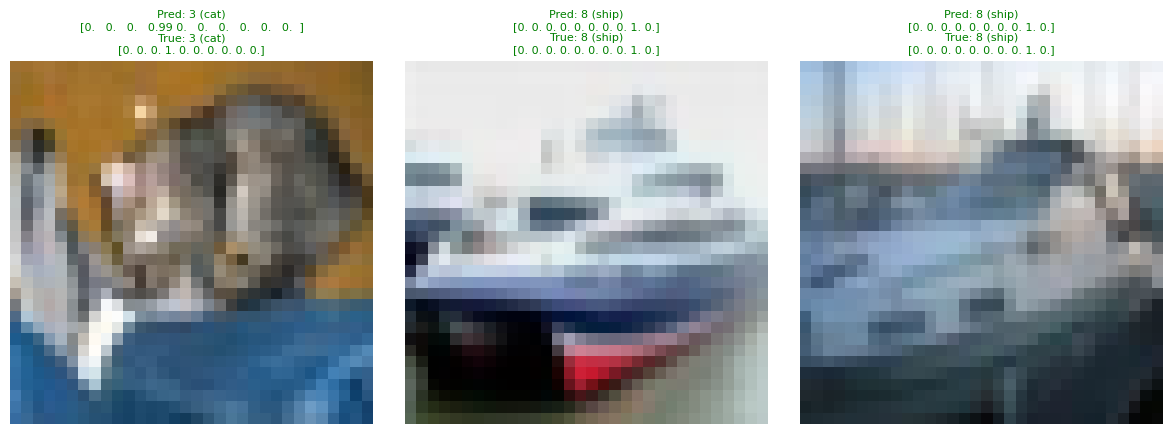


=== Unfreezing last 145 layers ===
Unfrozen: conv2_block3_1_bn (index 30)
Unfrozen: conv2_block3_1_relu (index 31)
Unfrozen: conv2_block3_2_conv (index 32)
Unfrozen: conv2_block3_2_bn (index 33)
Unfrozen: conv2_block3_2_relu (index 34)
Unfrozen: conv2_block3_3_conv (index 35)
Unfrozen: conv2_block3_3_bn (index 36)
Unfrozen: conv2_block3_add (index 37)
Unfrozen: conv2_block3_out (index 38)
Unfrozen: conv3_block1_1_conv (index 39)
Unfrozen: conv3_block1_1_bn (index 40)
Unfrozen: conv3_block1_1_relu (index 41)
Unfrozen: conv3_block1_2_conv (index 42)
Unfrozen: conv3_block1_2_bn (index 43)
Unfrozen: conv3_block1_2_relu (index 44)
Unfrozen: conv3_block1_0_conv (index 45)
Unfrozen: conv3_block1_3_conv (index 46)
Unfrozen: conv3_block1_0_bn (index 47)
Unfrozen: conv3_block1_3_bn (index 48)
Unfrozen: conv3_block1_add (index 49)
Unfrozen: conv3_block1_out (index 50)
Unfrozen: conv3_block2_1_conv (index 51)
Unfrozen: conv3_block2_1_bn (index 52)
Unfrozen: conv3_block2_1_relu (index 53)
Unfrozen

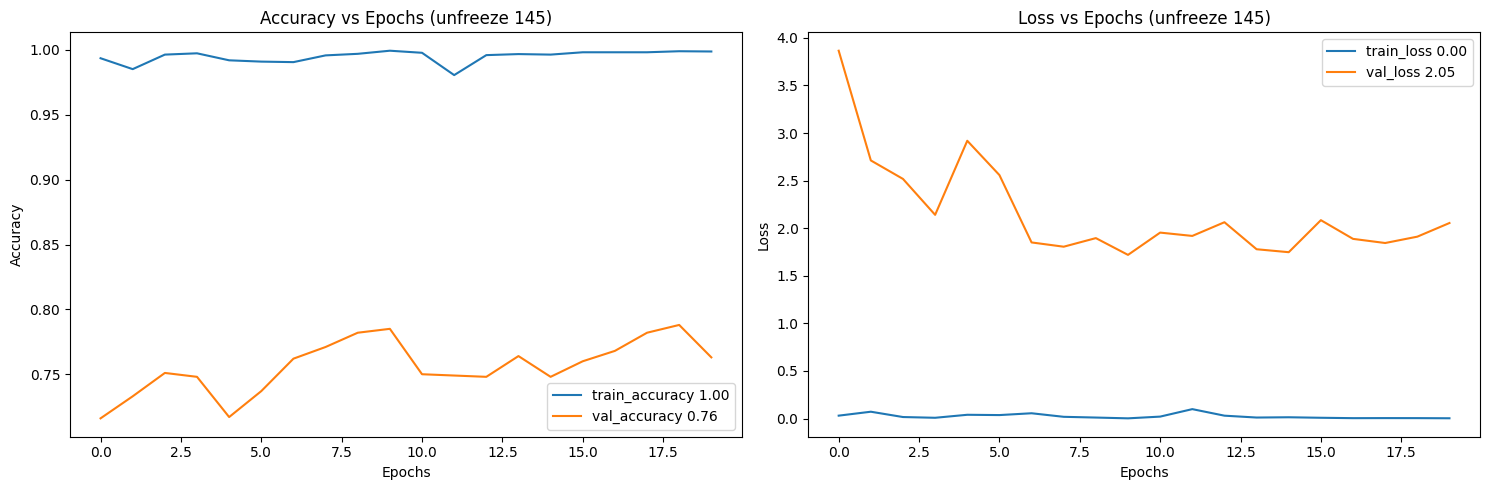

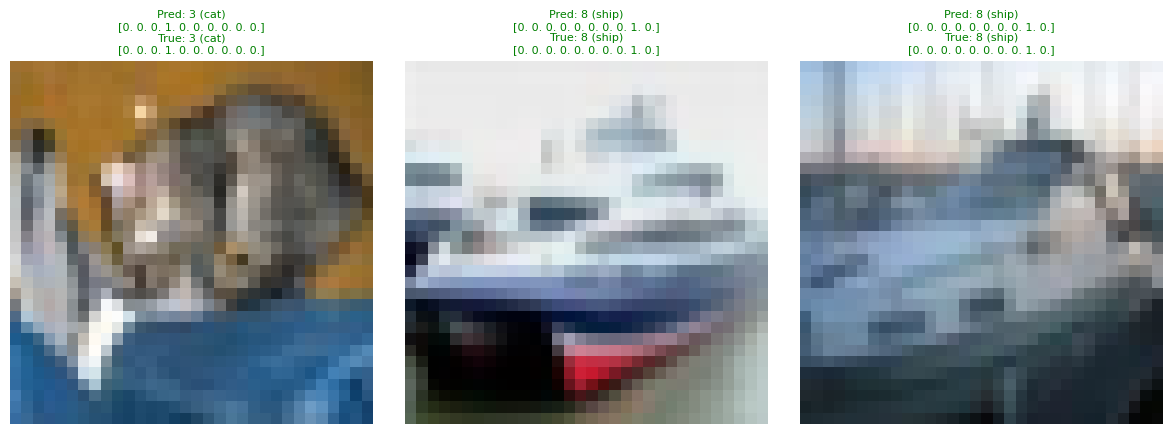


=== Unfreezing last 150 layers ===
Unfrozen: conv2_block2_3_conv (index 25)
Unfrozen: conv2_block2_3_bn (index 26)
Unfrozen: conv2_block2_add (index 27)
Unfrozen: conv2_block2_out (index 28)
Unfrozen: conv2_block3_1_conv (index 29)
Unfrozen: conv2_block3_1_bn (index 30)
Unfrozen: conv2_block3_1_relu (index 31)
Unfrozen: conv2_block3_2_conv (index 32)
Unfrozen: conv2_block3_2_bn (index 33)
Unfrozen: conv2_block3_2_relu (index 34)
Unfrozen: conv2_block3_3_conv (index 35)
Unfrozen: conv2_block3_3_bn (index 36)
Unfrozen: conv2_block3_add (index 37)
Unfrozen: conv2_block3_out (index 38)
Unfrozen: conv3_block1_1_conv (index 39)
Unfrozen: conv3_block1_1_bn (index 40)
Unfrozen: conv3_block1_1_relu (index 41)
Unfrozen: conv3_block1_2_conv (index 42)
Unfrozen: conv3_block1_2_bn (index 43)
Unfrozen: conv3_block1_2_relu (index 44)
Unfrozen: conv3_block1_0_conv (index 45)
Unfrozen: conv3_block1_3_conv (index 46)
Unfrozen: conv3_block1_0_bn (index 47)
Unfrozen: conv3_block1_3_bn (index 48)
Unfrozen

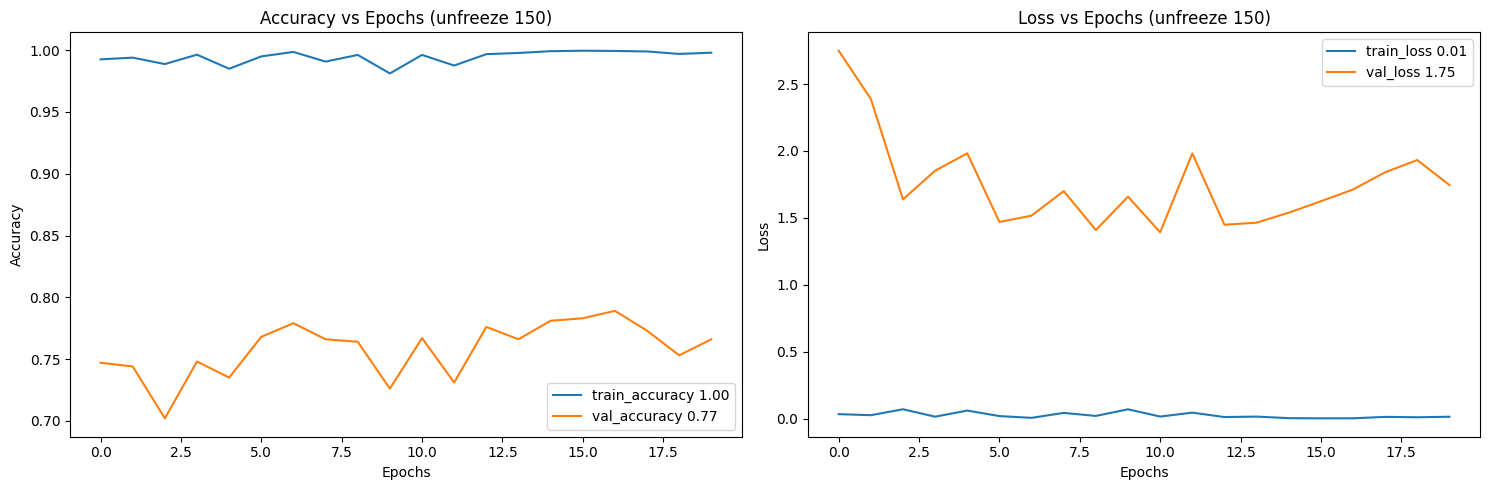

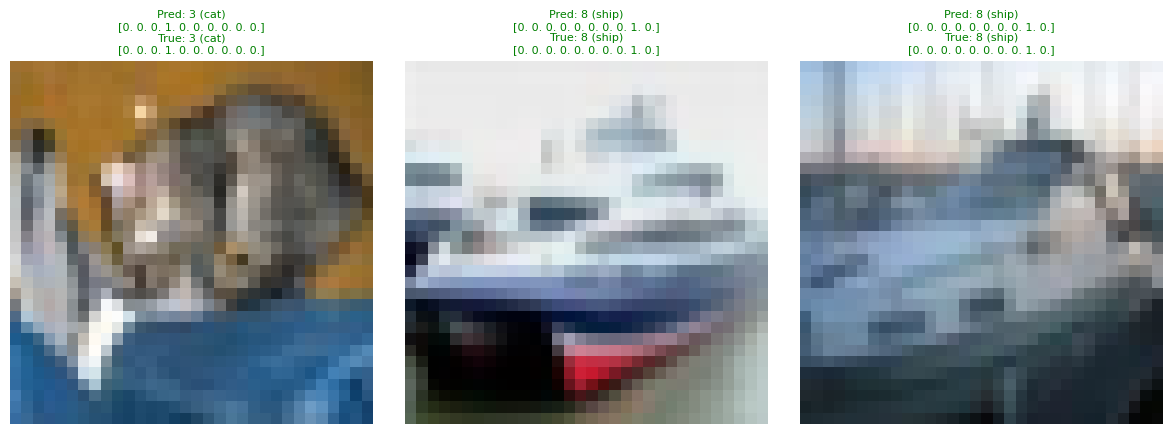


=== Unfreezing last 155 layers ===
Unfrozen: conv2_block2_1_bn (index 20)
Unfrozen: conv2_block2_1_relu (index 21)
Unfrozen: conv2_block2_2_conv (index 22)
Unfrozen: conv2_block2_2_bn (index 23)
Unfrozen: conv2_block2_2_relu (index 24)
Unfrozen: conv2_block2_3_conv (index 25)
Unfrozen: conv2_block2_3_bn (index 26)
Unfrozen: conv2_block2_add (index 27)
Unfrozen: conv2_block2_out (index 28)
Unfrozen: conv2_block3_1_conv (index 29)
Unfrozen: conv2_block3_1_bn (index 30)
Unfrozen: conv2_block3_1_relu (index 31)
Unfrozen: conv2_block3_2_conv (index 32)
Unfrozen: conv2_block3_2_bn (index 33)
Unfrozen: conv2_block3_2_relu (index 34)
Unfrozen: conv2_block3_3_conv (index 35)
Unfrozen: conv2_block3_3_bn (index 36)
Unfrozen: conv2_block3_add (index 37)
Unfrozen: conv2_block3_out (index 38)
Unfrozen: conv3_block1_1_conv (index 39)
Unfrozen: conv3_block1_1_bn (index 40)
Unfrozen: conv3_block1_1_relu (index 41)
Unfrozen: conv3_block1_2_conv (index 42)
Unfrozen: conv3_block1_2_bn (index 43)
Unfrozen

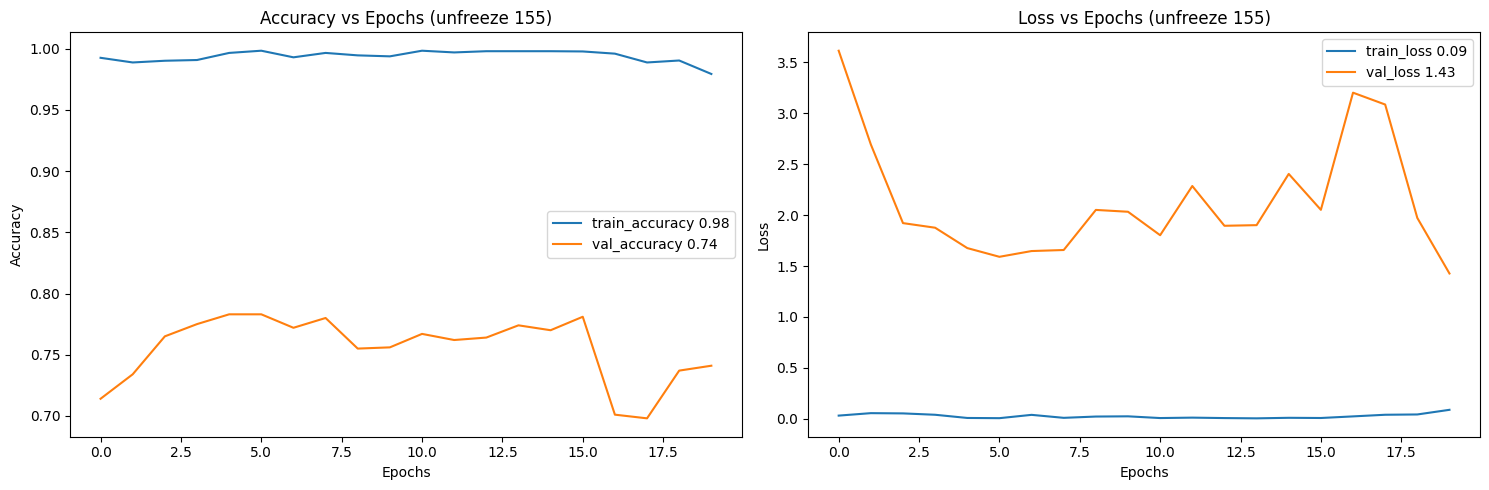

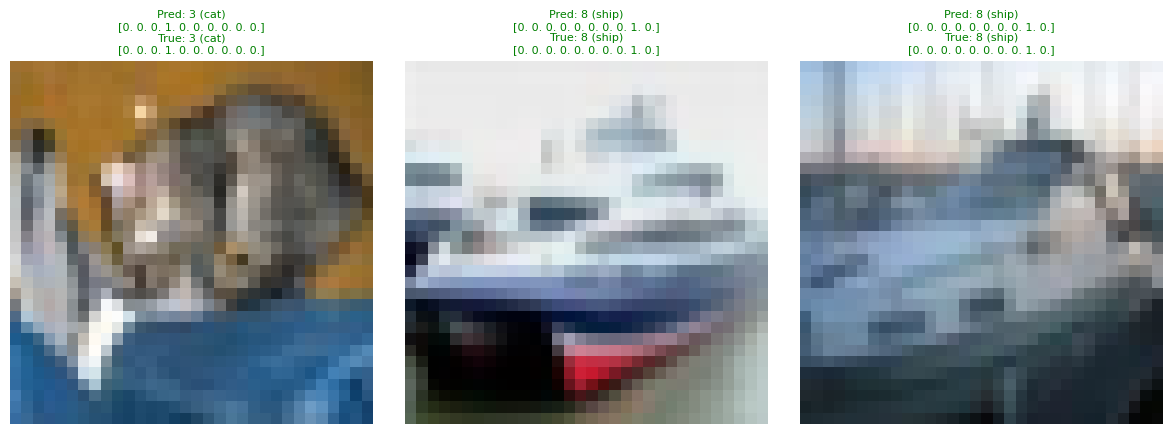


=== Unfreezing last 160 layers ===
Unfrozen: conv2_block1_0_bn (index 15)
Unfrozen: conv2_block1_3_bn (index 16)
Unfrozen: conv2_block1_add (index 17)
Unfrozen: conv2_block1_out (index 18)
Unfrozen: conv2_block2_1_conv (index 19)
Unfrozen: conv2_block2_1_bn (index 20)
Unfrozen: conv2_block2_1_relu (index 21)
Unfrozen: conv2_block2_2_conv (index 22)
Unfrozen: conv2_block2_2_bn (index 23)
Unfrozen: conv2_block2_2_relu (index 24)
Unfrozen: conv2_block2_3_conv (index 25)
Unfrozen: conv2_block2_3_bn (index 26)
Unfrozen: conv2_block2_add (index 27)
Unfrozen: conv2_block2_out (index 28)
Unfrozen: conv2_block3_1_conv (index 29)
Unfrozen: conv2_block3_1_bn (index 30)
Unfrozen: conv2_block3_1_relu (index 31)
Unfrozen: conv2_block3_2_conv (index 32)
Unfrozen: conv2_block3_2_bn (index 33)
Unfrozen: conv2_block3_2_relu (index 34)
Unfrozen: conv2_block3_3_conv (index 35)
Unfrozen: conv2_block3_3_bn (index 36)
Unfrozen: conv2_block3_add (index 37)
Unfrozen: conv2_block3_out (index 38)
Unfrozen: conv

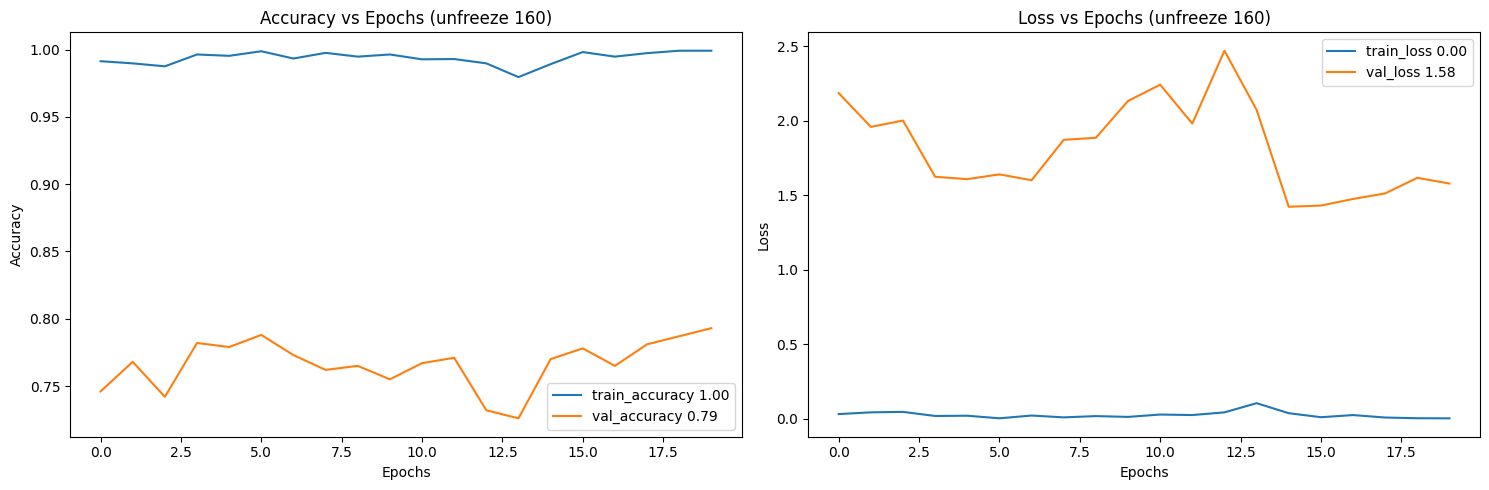

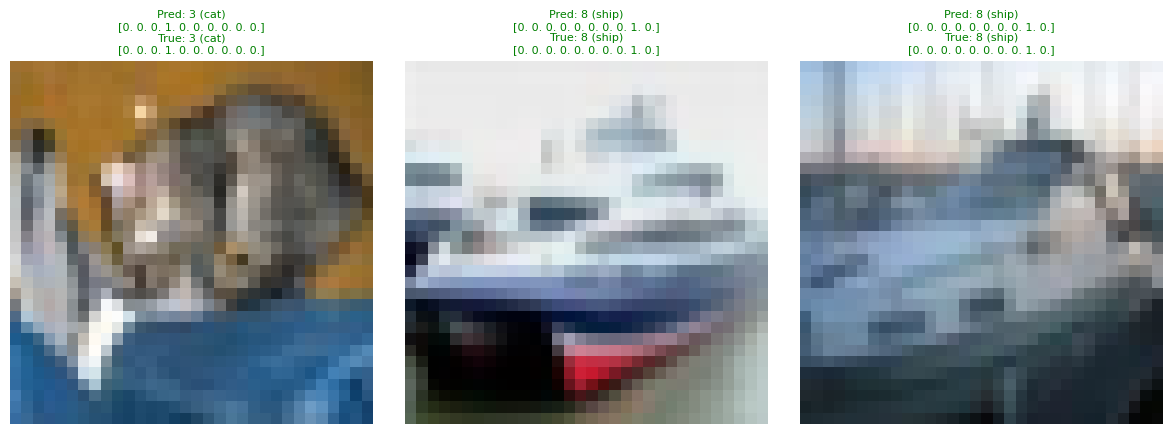


=== Unfreezing last 165 layers ===
Unfrozen: conv2_block1_2_conv (index 10)
Unfrozen: conv2_block1_2_bn (index 11)
Unfrozen: conv2_block1_2_relu (index 12)
Unfrozen: conv2_block1_0_conv (index 13)
Unfrozen: conv2_block1_3_conv (index 14)
Unfrozen: conv2_block1_0_bn (index 15)
Unfrozen: conv2_block1_3_bn (index 16)
Unfrozen: conv2_block1_add (index 17)
Unfrozen: conv2_block1_out (index 18)
Unfrozen: conv2_block2_1_conv (index 19)
Unfrozen: conv2_block2_1_bn (index 20)
Unfrozen: conv2_block2_1_relu (index 21)
Unfrozen: conv2_block2_2_conv (index 22)
Unfrozen: conv2_block2_2_bn (index 23)
Unfrozen: conv2_block2_2_relu (index 24)
Unfrozen: conv2_block2_3_conv (index 25)
Unfrozen: conv2_block2_3_bn (index 26)
Unfrozen: conv2_block2_add (index 27)
Unfrozen: conv2_block2_out (index 28)
Unfrozen: conv2_block3_1_conv (index 29)
Unfrozen: conv2_block3_1_bn (index 30)
Unfrozen: conv2_block3_1_relu (index 31)
Unfrozen: conv2_block3_2_conv (index 32)
Unfrozen: conv2_block3_2_bn (index 33)
Unfrozen

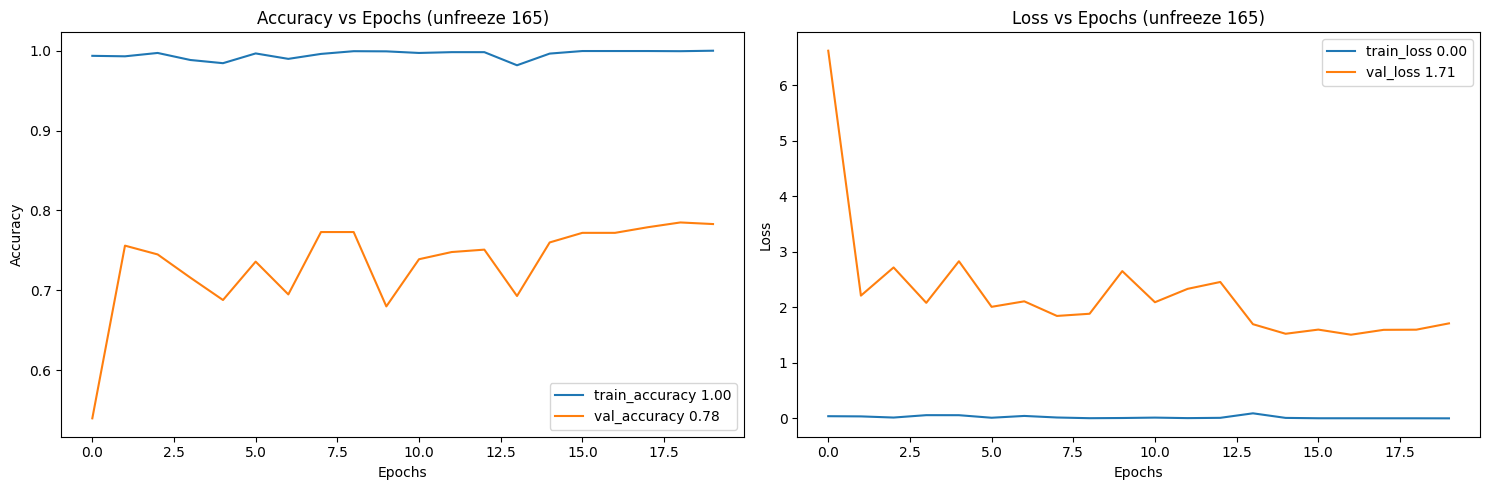

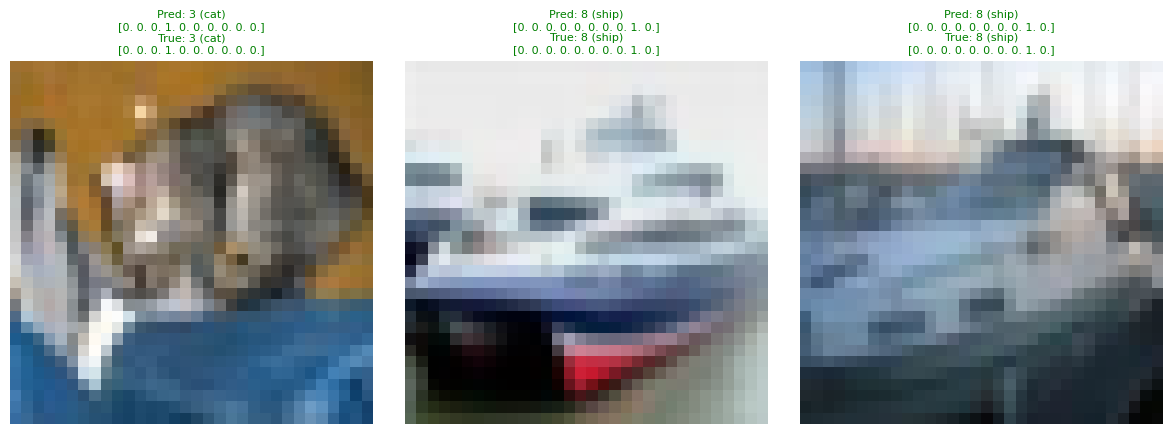


=== Unfreezing last 170 layers ===
Unfrozen: pool1_pad (index 5)
Unfrozen: pool1_pool (index 6)
Unfrozen: conv2_block1_1_conv (index 7)
Unfrozen: conv2_block1_1_bn (index 8)
Unfrozen: conv2_block1_1_relu (index 9)
Unfrozen: conv2_block1_2_conv (index 10)
Unfrozen: conv2_block1_2_bn (index 11)
Unfrozen: conv2_block1_2_relu (index 12)
Unfrozen: conv2_block1_0_conv (index 13)
Unfrozen: conv2_block1_3_conv (index 14)
Unfrozen: conv2_block1_0_bn (index 15)
Unfrozen: conv2_block1_3_bn (index 16)
Unfrozen: conv2_block1_add (index 17)
Unfrozen: conv2_block1_out (index 18)
Unfrozen: conv2_block2_1_conv (index 19)
Unfrozen: conv2_block2_1_bn (index 20)
Unfrozen: conv2_block2_1_relu (index 21)
Unfrozen: conv2_block2_2_conv (index 22)
Unfrozen: conv2_block2_2_bn (index 23)
Unfrozen: conv2_block2_2_relu (index 24)
Unfrozen: conv2_block2_3_conv (index 25)
Unfrozen: conv2_block2_3_bn (index 26)
Unfrozen: conv2_block2_add (index 27)
Unfrozen: conv2_block2_out (index 28)
Unfrozen: conv2_block3_1_conv 

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_36/1997537650.py", line 24, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 4915160040 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_1375906]

In [ ]:
histories = {}

# Loop over different numbers of layers to unfreeze
for num_layers_to_unfreeze in range(5, len(base_model.layers)+1,5):  # unfreeze last layers in step of 5
    print(f"\n=== Unfreezing last {num_layers_to_unfreeze} layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers[-num_layers_to_unfreeze:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {len(base_model.layers)-num_layers_to_unfreeze+i})")

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Store history
    histories[f"unfreeze_{num_layers_to_unfreeze}"] = history

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )
    plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)

### Evaluating effect of unfreezing the layers

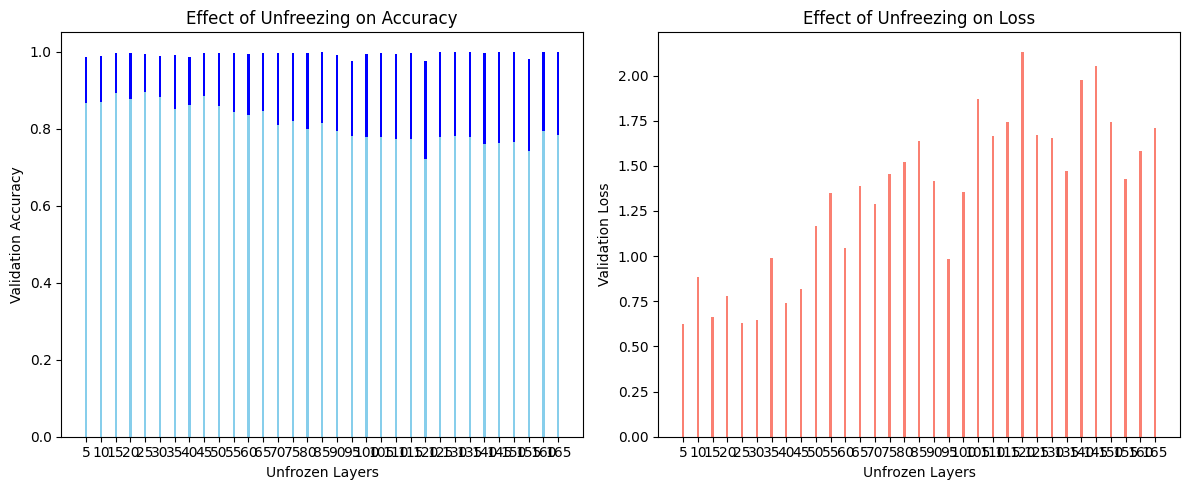

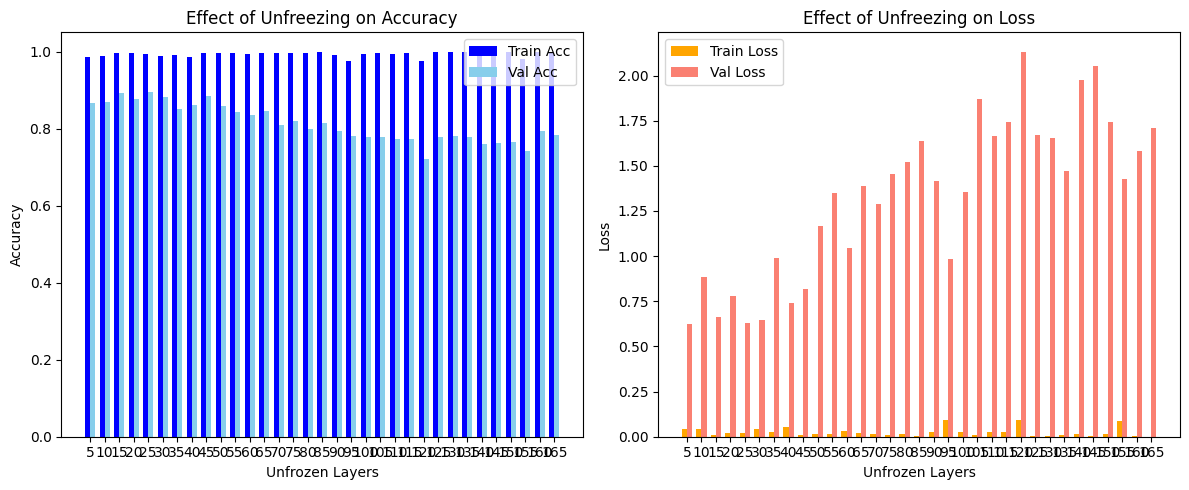

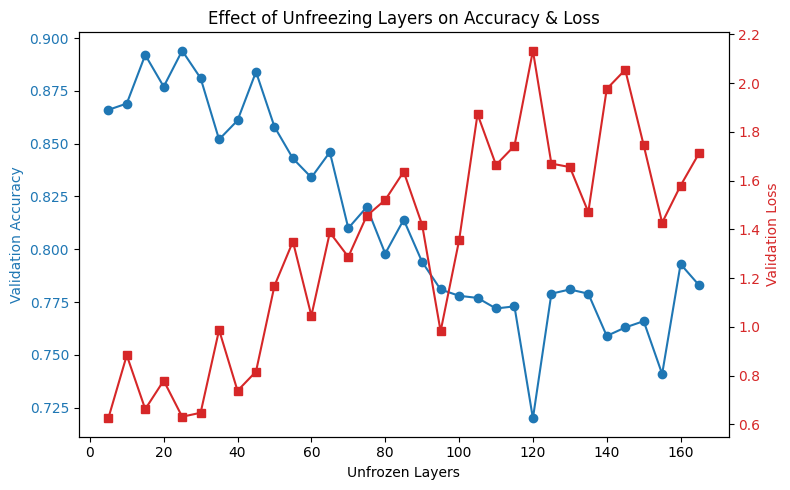

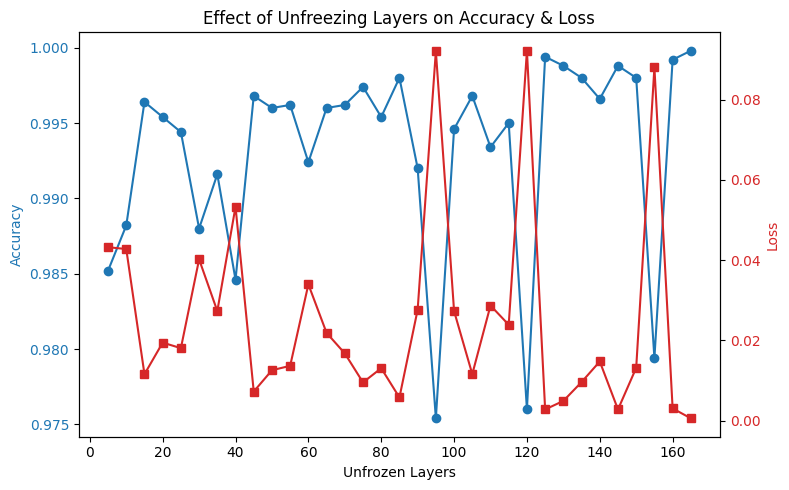

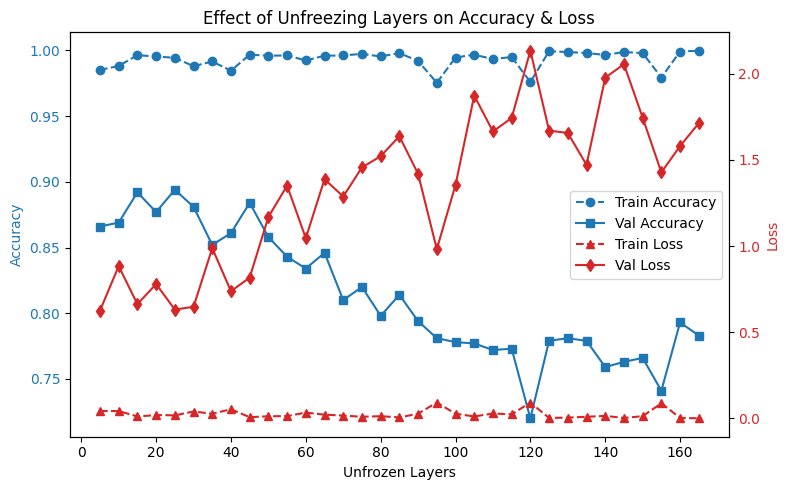

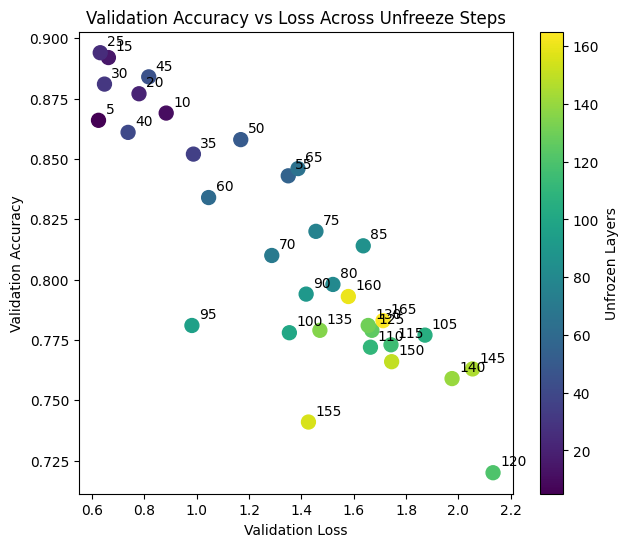

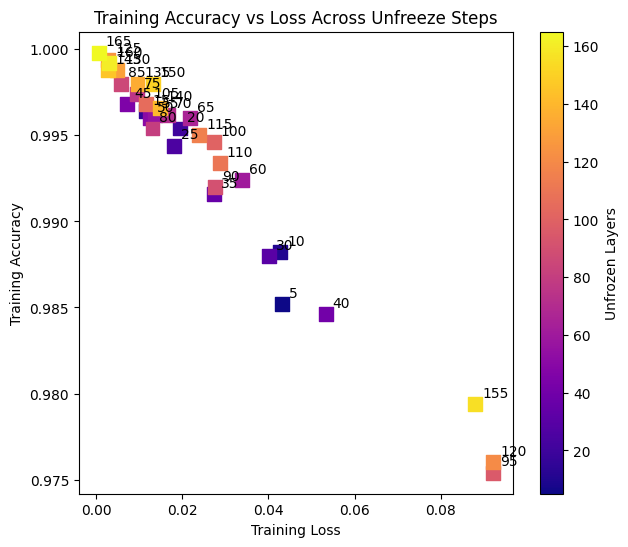

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results from histories
unfreeze_counts = []
final_val_acc = []
final_acc = []
final_val_loss = []
final_loss = []

for key, history in histories.items():
    unfreeze_num = int(key.split("_")[1])  
    acc = history.history["val_accuracy"][-1]
    loss = history.history["val_loss"][-1]
    accf = history.history["accuracy"][-1]
    lossf = history.history["loss"][-1]
    unfreeze_counts.append(unfreeze_num)
    final_val_acc.append(acc)
    final_val_loss.append(loss)
    final_acc.append(accf)
    final_loss.append(lossf)

# Sort results by number of unfrozen layers
order = np.argsort(unfreeze_counts)
unfreeze_counts = np.array(unfreeze_counts)[order]
final_val_acc = np.array(final_val_acc)[order]
final_val_loss = np.array(final_val_loss)[order]
final_acc = np.array(final_acc)[order]
final_loss = np.array(final_loss)[order]

# --- 1. Side-by-side Bar Charts (Accuracy & Loss) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(unfreeze_counts, final_acc, color="blue")
axes[0].bar(unfreeze_counts, final_val_acc, color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(unfreeze_counts)
axes[1].bar(unfreeze_counts, final_loss, color="orange")
axes[1].bar(unfreeze_counts, final_val_loss, color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(unfreeze_counts)

plt.tight_layout()
plt.show()

#####
x = np.arange(len(unfreeze_counts))  # positions for bars
width = 0.35  # width of each bar

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy ---
axes[0].bar(x - width/2, final_acc, width, label="Train Acc", color="blue")
axes[0].bar(x + width/2, final_val_acc, width, label="Val Acc", color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(x)
axes[0].set_xticklabels(unfreeze_counts)
axes[0].legend()

# --- Loss ---
axes[1].bar(x - width/2, final_loss, width, label="Train Loss", color="orange")
axes[1].bar(x + width/2, final_val_loss, width, label="Val Loss", color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(x)
axes[1].set_xticklabels(unfreeze_counts)
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 2. Dual-axis Line Plot (Accuracy + Loss vs Layers) ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Validation Accuracy", color=color)
ax1.plot(unfreeze_counts, final_val_acc, marker="o", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Validation Loss", color=color)
ax2.plot(unfreeze_counts, final_val_loss, marker="s", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()
################
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(unfreeze_counts, final_acc, marker="o", color=color, label="Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Loss", color=color)
ax2.plot(unfreeze_counts, final_loss, marker="s", color=color, label="Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()
#####
# --- Dual-axis Line Plot with Training + Validation ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(unfreeze_counts, final_acc, marker="o", linestyle="--", color=color, label="Train Accuracy")
ax1.plot(unfreeze_counts, final_val_acc, marker="s", linestyle="-", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Loss", color=color)
ax2.plot(unfreeze_counts, final_loss, marker="^", linestyle="--", color=color, label="Train Loss")
ax2.plot(unfreeze_counts, final_val_loss, marker="d", linestyle="-", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc="center right")

fig.tight_layout()
plt.show()

# --- 3. Scatter Plot (Accuracy vs Loss Trade-off) ---

# --- Scatter: Validation ---
plt.figure(figsize=(7,6))
plt.scatter(final_val_loss, final_val_acc, c=unfreeze_counts, cmap="viridis", s=100, marker="o")
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_val_loss[i], final_val_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Validation Loss")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()

# --- Scatter: Training ---
plt.figure(figsize=(7,6))
plt.scatter(final_loss, final_acc, c=unfreeze_counts, cmap="plasma", s=100, marker="s")
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_loss[i], final_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Training Loss")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()



### Conclusion
#### As we progressively unfreeze higher-order layers of the base model, the network gradually adapts and transforms into a completely new model. However, unfreezing layers increases the risk of overfitting. To mitigate this, fine-tuning with careful adjustment of hyperparameters such as learning rate, batch size, and regularization becomes essential.to overfit. To avoid this we need to fine tune the model by changing hyper parameters

In [ ]:
    print(f"\n=== Unfreezing layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers):
        layer.trainable = True
        

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )
    plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)

In [ ]:
# -------------------------
# 5. Progressive unfreezing (block by block)
# -------------------------
'''def unfreeze_block(block_num):
    for layer in base_model.layers:
        if f'block{block_num}_' in layer.name:
            layer.trainable = True

blocks_to_unfreeze = [5, 4]  # you can add 3, 2, 1 for deeper fine-tuning
fine_tune_histories = []

for block in blocks_to_unfreeze:
    print(f"\n--- Unfreezing block {block} ---")
    unfreeze_block(block)
    model.compile(optimizer=optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    hist = model.fit(train_ds, validation_data=val_ds, epochs=3)
    fine_tune_histories.append(hist)'''
    
# -------------------------
# Unfreeze a slice of layers
# -------------------------
'''def unfreeze_slice(start=None, end=None):
    """
    Unfreezes layers[start:end] (Python slicing rules).
    Example:
        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end
        unfreeze_slice(None, 4)   # unfreeze first 4 layers
    """
    for i, layer in enumerate(base_model.layers[start:end]):
        layer.trainable = True
        #layer.trainable = False
        print(f"Unfrozen: {layer.name} (index {i})")

unfreeze_slice(15,None)'''